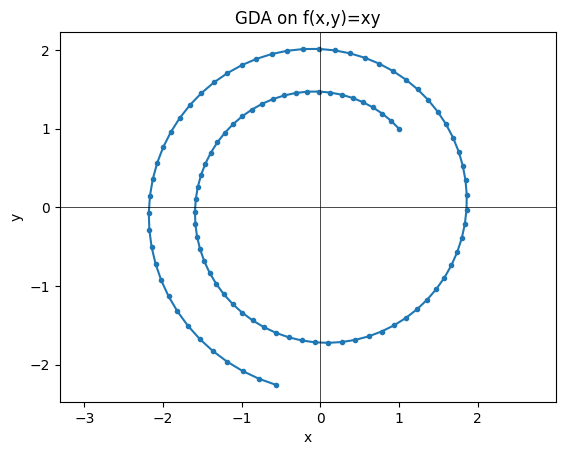

In [1]:
import numpy as np
import matplotlib.pyplot as plt

eta = 0.1
T = 100
x, y = 1.0, 1.0  # 初始点
xs, ys = [x], [y]

for _ in range(T):
    x, y = x - eta * y, y + eta * x  # GDA 更新
    xs.append(x); ys.append(y)

plt.plot(xs, ys, 'o-', markersize=3)
plt.axhline(0, color='k', linewidth=0.5)
plt.axvline(0, color='k', linewidth=0.5)
plt.title("GDA on f(x,y)=xy")
plt.xlabel("x"); plt.ylabel("y")
plt.axis('equal')
plt.show()


In [1]:
c = 3e8  # speed of light (m/s)
fc = 10e9  # Carrier frequency: 10 GHz
wavelength = c / fc
bandwidth = 100e6  # 100 MHz
tx_power_dbm = 30  #  dBm
jam_power_dbm = 50
k = 1.38e-23  # Boltzmann 
GT = 13 # db gain-to-noise-temperature for for 0.33m Equivalent satellite antenna aperturesatellites, or can be 5 dB K^(-1) for 0.13m Equivalent satellite antenna aperture
La = 5 # dB
GT_linear_inv = 10 ** (-GT / 10)
La_linear = 10 ** (La / 10)
noise_power_watt = k * bandwidth * GT_linear_inv * La_linear
Tx_power_watt = 10 ** ((tx_power_dbm  - 30)/ 10)  
jam_power_watt = 10 ** ((jam_power_dbm  - 30)/ 10)

In [2]:
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu, compute_az_el_dist
import numpy as np


# Generate RX positions

distances_km = [0.4]
azimuths_deg = np.linspace(0, 360, len(distances_km), endpoint=False)
gnd_positions = [np.array([0.0, 0.0, 0.0])]

for d_km, az in zip(distances_km, azimuths_deg):
    pos = arc_point_on_earth(d_km, az)
    gnd_positions.append(pos)
gnd_positions = np.array(gnd_positions)

for i, pos in enumerate(gnd_positions):
    print(f"TX{i}(m): {pos}")


# Compute SAT intersection points

sat_orbit_m = 550e3
# angles = [(120, 80),(45, 90), (75,75),(80,88), (65, 85),(130,75)]
# angles = [(45, 90-(1e-3)), (120, 87), (75,85),(80,83), (65, 82),(130,80)]
angles = [(45, 90-(1e-3)), (120, 87), (75,85)]
sat_positions = []
delays_ms = []
fspl_db = []
frequency_hz = 10e9 
wavelength = 3e8 / frequency_hz

for az, el in angles:
    pos, delay, dist = compute_satellite_intersection_point_enu(az, el, sat_orbit_m)
    sat_positions.append(pos)
    delays_ms.append(delay)
    fspl = 20 * np.log10(4 * np.pi * dist / wavelength)
    fspl_db.append(fspl)

sat_positions = np.array(sat_positions)
delays_ms = np.array(delays_ms)
fspl_db = np.array(fspl_db)

print("\nSatellite Pos [m]:\n", sat_positions)
# print("\nPropagation delays [ms]:\n", delays_ms)
# print("\nFree-space path loss [dB]:\n", fspl_db)


# Compute az/el/dist per TX-SAT
  
for i, tx in enumerate(gnd_positions):
    print(f"\nFrom TX{i}:")
    for j, sat in enumerate(sat_positions):
        az, el, dist, n_waves = compute_az_el_dist(sat, tx, frequency_hz)
        print(f"  SAT{j}: az={az:.2f}°, el={el:.2f}°, dist={dist:.2f} m, λ count ≈ {n_waves:.2f}")


TX0(m): [0. 0. 0.]
TX1(m): [ 2.44929360e-14  4.00000000e+02 -1.25568981e-02]

Satellite Pos [m]:
 [[ 6.78773782e+00  6.78773782e+00  5.50000000e+05]
 [ 2.49598339e+04 -1.44105668e+04  5.49939990e+05]
 [ 4.64650302e+04  1.24502673e+04  5.49832825e+05]]

From TX0:
  SAT0: az=45.00°, el=90.00°, dist=550000.00 m, λ count ≈ 18333333.34
  SAT1: az=120.00°, el=87.00°, dist=550694.70 m, λ count ≈ 18356489.92
  SAT2: az=75.00°, el=85.00°, dist=551933.10 m, λ count ≈ 18397769.90

From TX1:
  SAT0: az=179.01°, el=89.96°, dist=550000.15 m, λ count ≈ 18333338.44
  SAT1: az=120.68°, el=86.98°, dist=550705.32 m, λ count ≈ 18356844.09
  SAT2: az=75.46°, el=85.01°, dist=551924.23 m, λ count ≈ 18397474.38


In [3]:
from sionna.rt import Scene, Receiver, Transmitter, PlanarArray, PathSolver
import numpy as np

def compute_cir(tx_pos, rx_pos, tx_array, rx_array,tx_look_at, rx_look_at, frequency=10e9):
    """
    Compute CIR from a single transmitter to multiple receivers using synthetic arrays.
    
    Args:
        tx_pos:        (3,) list or np.array for transmitter position
        rx_pos_array:  (m,3) array of receiver positions
        tx_array:      PlanarArray for the transmitter
        rx_array:      PlanarArray for all receivers (shared)
        frequency:     Frequency in Hz

    Returns:
        a_list:    list of CIR amplitude arrays, one per RX
        tau_list:  list of delay arrays, one per RX
    """
    scene = Scene()
    scene.frequency = frequency
    scene.synthetic_array = True

    # Add transmitter
    scene.tx_array = tx_array
    tx = Transmitter(name="tx", position=tx_pos, display_radius=200)
    scene.add(tx)

    # Add receivers
    scene.rx_array = rx_array
    rx_list = []
    for i, rx_pos in enumerate(rx_pos):
        rx = Receiver(name=f"rx{i}", position=rx_pos)
        scene.add(rx)
        rx.look_at(rx_look_at)
        rx_list.append(rx)

    tx.look_at(tx_look_at)  # Point TX to the first RX

    # Solve paths
    solver = PathSolver()
    paths = solver(scene=scene,
                   max_depth=0,
                   los=True,
                   synthetic_array=True,
                   seed=41)

    # Get CIRs
    a_all, tau_all = paths.cir(normalize_delays=False, out_type="numpy")

    for tx_name in scene.transmitters:
        scene.remove(tx_name)
    for rx_name in scene.receivers:
        scene.remove(rx_name) 
    
    return a_all, tau_all


jitc_llvm_init(): LLVM API initialization failed ..


In [4]:
import vsat_dish_3gpp
jam_rows =8
jam_cols = 8
jam_antennas = jam_cols*jam_rows

sat_rows = 1
sat_cols = 1
sat_antennas = sat_cols*sat_rows

tx_rows = 8
tx_cols = 8
tx_antennas = tx_cols*tx_rows

tx_array = PlanarArray(num_rows=tx_rows, num_cols=tx_cols,
                        vertical_spacing=0.5, horizontal_spacing=0.5,
                        pattern="tr38901", polarization="V")
                        # pattern="iso", polarization="V")

jam_array = PlanarArray(num_rows=jam_rows, num_cols=jam_cols,  
                            vertical_spacing=0.5, horizontal_spacing=0.5,
                        #  pattern="vsat_dish",
                            pattern="tr38901",
                            polarization="V")

sat_array = PlanarArray(num_rows=sat_rows, num_cols=sat_cols,
                             vertical_spacing=0.5, horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")




In [5]:
import numpy as np
from numpy.linalg import cholesky, solve, eigh

def collapse_channel(a_cir, t_idx=0):
    """
    Collapse channel tensor at a given time index.
    Input:
      a_cir: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
    Output:
      H_t: (M, N), M = num_rx*num_rx_ant, N = num_tx*num_tx_ant
    """
    nr, nra, nt, nta, npaths, ntimes = a_cir.shape
    assert 0 <= t_idx < ntimes
    H_t = a_cir[..., t_idx]             # select time slice
    H_t = H_t.sum(axis=-1)              # sum over paths
    H_t = H_t.reshape(nr*nra, nt*nta)   # merge Rx/Tx antennas
    return H_t




In [7]:


# # ========== 2) User water-filling  ==========
# def waterfilling_Q0(H0, P, P0, mode='auto', tol=1e-9, max_iter=80):
#     """
#     Input:
#       H0: (M,N),  P: (M,M) = N I + H1 Q1 H1^H,  P0 = total power
#       mode: 'rank1' → single stream, 'auto' → multi-stream water-filling
#     Output:
#       Q0: (N,N) covariance
#       w0: (N,d0) unit-norm directions
#       p : (d0,) per-stream power (sum = P0)
#       V : eigenvectors of A^H A
#     """
#     # whitening: P^{-1/2} H0
#     evals, evecs = eigh(P)
#     evals = np.maximum(evals, 1e-15)
#     Pinv_half = evecs @ np.diag(evals**-0.5) @ evecs.conj().T
#     A = Pinv_half @ H0

#     # eigen-decomposition of A^H A (descending order)
#     G = A.conj().T @ A
#     lam, V = eigh(G)
#     idx = np.argsort(lam)[::-1]
#     lam, V = lam[idx], V[:, idx]
#     lam = np.maximum(lam, 0.0)

#     if mode == 'rank1':
#         v1 = V[:, 0] / (np.linalg.norm(V[:, 0]) + 1e-15)
#         p = np.array([P0], dtype=float)
#         Q0 = P0 * np.outer(v1, v1.conj())
#         w0 = v1.reshape(-1, 1)
#         return Q0, w0, p, V

#     elif mode == 'auto':
#         # bisection search for water level μ
#         def power_at(mu):
#             inv_lam = 1.0 / np.maximum(lam, 1e-15)
#             p = np.maximum(0.0, 1.0/mu - inv_lam)
#             return p, p.sum()

#         mu_lo, mu_hi = 1e-15, lam[0] + 1.0
#         p_try, tot = power_at(mu_hi)
#         k = 0
#         while tot > P0 and k < 30:
#             mu_hi *= 2.0
#             p_try, tot = power_at(mu_hi)
#             k += 1

#         for _ in range(max_iter):
#             mu_mid = 0.5 * (mu_lo + mu_hi)
#             p_try, tot = power_at(mu_mid)
#             if tot > P0:
#                 mu_lo = mu_mid
#             else:
#                 mu_hi = mu_mid
#             if abs(tot - P0) <= tol:
#                 break

#         p_all, tot = power_at(mu_hi)
#         if tot > 0:
#             p_all *= (P0 / tot)

#         mask = p_all > 1e-12
#         Vp = V[:, mask].copy() if np.any(mask) else np.zeros((V.shape[0], 0), dtype=complex)
#         for j in range(Vp.shape[1]):
#             Vp[:, j] /= (np.linalg.norm(Vp[:, j]) + 1e-15)

#         p = p_all[mask]
#         Q0 = (Vp * p) @ Vp.conj().T
#         w0 = Vp
#         return Q0, w0, p, V

#     else:
#         raise ValueError("mode must be 'rank1' or 'auto'")


# # ========== 3) Jammer best response (KKT subspace; unit-norm) ==========
# def jammer_best_Q1(
#     H0, Q0, H1, N0, P1,
#     Q1_current=None,
#     mode='auto',
#     power_alloc='equal'   # 'equal' | 'proportional' | 'line_search'
# ):
#     """
#     Given Q0, build P = N0 I + H1 Q1 H1^H (if Q1_current=None, set Q1=0).
#     Then form B = H1^H [P^{-1} - (P+S)^{-1}] H1 using Woodbury identity.
#     Choose dominant eigenspace, allocate power.
#     Output:
#       Q1_new: (N,N) new covariance
#       w1: (N,r) unit-norm directions
#       q : (r,) per-stream power (sum = P1)
#       B, bvals, E: diagnostics
#     """
#     M, N = H0.shape[0], H1.shape[1]
#     S = H0 @ Q0 @ H0.conj().T

#     P = N0 * np.eye(M, dtype=complex)
#     if Q1_current is not None:
#         P = P + H1 @ Q1_current @ H1.conj().T

#     # Cholesky with jitter
#     try:
#         L = cholesky(P)
#     except np.linalg.LinAlgError:
#         eps = 1e-12 * np.trace(P).real / M
#         L = cholesky(P + eps * np.eye(M, dtype=complex))

#     Linv = solve(L, np.eye(M, dtype=complex))
#     Pinv_half = Linv.conj().T

#     # Z = (I+T)^{-1} T
#     T = Pinv_half @ S @ Linv
#     Z = solve(np.eye(M, dtype=complex) + T, T)

#     B = H1.conj().T @ (Pinv_half @ Z @ Pinv_half.conj().T) @ H1

#     bvals, E = eigh(B)
#     idx = np.argsort(bvals)[::-1]
#     bvals, E = bvals[idx], E[:, idx]

#     if bvals[0] <= 0:
#         Q1_new = np.zeros((N, N), dtype=complex)
#         w1 = E[:, :1]
#         q = np.array([0.0])
#         return Q1_new, w1, q, B, bvals, E

#     if mode == 'rank1':
#         r = 1
#     else:
#         tol = max(1e-12, 1e-8 * abs(bvals[0]))
#         r = int(np.sum(np.abs(bvals - bvals[0]) <= tol))
#         r = max(r, 1)

#     E1 = E[:, :r]
#     b1 = bvals[:r].copy()

#     if power_alloc == 'equal' or r == 1:
#         q = np.ones(r) * (P1 / r)
#     elif power_alloc == 'proportional':
#         w = np.maximum(b1, 0.0)
#         q = np.ones(r) * (P1 / r) if w.sum() <= 0 else P1 * (w / w.sum())
#     elif power_alloc == 'line_search':
#         q = np.ones(r) * (P1 / r)
#         steps = 5
#         alpha = P1 / (10.0 * (1.0 + np.max(b1)))
#         for _ in range(steps):
#             g = -b1
#             q = q - alpha * g
#             q = np.maximum(q, 0.0)
#             s = q.sum()
#             q = np.ones(r) * (P1 / r) if s <= 0 else q * (P1 / s)
#     else:
#         raise ValueError("power_alloc must be in {'equal','proportional','line_search'}")

#     Q1_new = (E1 * q) @ E1.conj().T
#     w1 = E1
#     return Q1_new, w1, q, B, bvals, E


# # ========== 4) Alternating best responses loop ==========
# def solve_game(H0, H1, N0, P0, P1, max_iter=20, tol=1e-6, multi_stream=True,
#                verbose=False, track_err=False, track_J=False):
#     """
#     Alternating best responses between user (water-filling) and jammer (KKT eigenspace).

#     Returns:
#       Q0, w0, Q1, w1, B, n_iter[, err_hist, J_hist]
#         Q0: (N,N) user covariance
#         w0: (N,d0) user unit-norm beam(s)
#         Q1: (N,N) jammer covariance
#         w1: (N,r) jammer unit-norm beam(s)
#         B : (N,N) jammer KKT matrix
#         n_iter: iterations used
#         err_hist (optional): convergence history ||Q1_new - Q1||_F / ||Q1||_F
#         J_hist   (optional): rate history J(Q0,Q1) in bits/s/Hz
#     """
#     M, N = H0.shape[0], H0.shape[1]
#     Q1 = np.zeros((N, N), dtype=complex)  # initialize: no jamming

#     err_hist = [] if track_err else None
#     J_hist = [] if track_J else None

#     # Helper to compute J (log-det rate) without code duplication
#     def _compute_J(Q0, Q1):
#         # J = log2 det(I + H0 Q0 H0^H P^{-1}), with P = N0 I + H1 Q1 H1^H
#         P = N0*np.eye(M, dtype=complex) + H1 @ Q1 @ H1.conj().T
#         # solve P^{-1}S
#         try:
#             L = np.linalg.cholesky(P)
#         except np.linalg.LinAlgError:
#             eps = 1e-12 * np.trace(P).real / M
#             L = np.linalg.cholesky(P + eps*np.eye(M, dtype=complex))
#         S = H0 @ Q0 @ H0.conj().T
#         Y = np.linalg.solve(L, S)
#         PinvS = np.linalg.solve(L.conj().T, Y)
#         I_plus = np.eye(M, dtype=complex) + PinvS
#         sign, logdet = np.linalg.slogdet(I_plus)
#         if sign <= 0:
#             # fallback: logdet via Cholesky if numerical issues
#             Li = np.linalg.cholesky(I_plus)
#             logdet = 2.0*np.sum(np.log(np.abs(np.diag(Li))))
#         return logdet / np.log(2.0)

#     n_iter = 0
#     for it in range(1, max_iter + 1):
#         P = N0 * np.eye(M, dtype=complex) + H1 @ Q1 @ H1.conj().T

#         # User best response
#         Q0, w0, p, V = waterfilling_Q0(H0, P, P0, mode='rank1' if not multi_stream else 'auto')
#         # if not multi_stream:
#         #     # enforce rank-1 Q0 with unit-norm beam
#         #     w0_dir = w0[:, 0] if w0.shape[1] > 0 else V[:, 0]
#         #     w0_dir = w0_dir / (np.linalg.norm(w0_dir) + 1e-15)
#         #     Q0 = P0 * np.outer(w0_dir, w0_dir.conj())
#         #     w0 = w0_dir.reshape(-1, 1)

#         # Jammer best response
#         Q1_new, w1, q, B, bvals, E = jammer_best_Q1(
#             H0, Q0, H1, N0, P1, Q1_current=Q1,
#             mode='rank1' if not multi_stream else 'auto'
#         )

#         # Logging and convergence
#         denom = max(np.linalg.norm(Q1, 'fro'), 1.0)
#         err = np.linalg.norm(Q1_new - Q1, 'fro') / denom
#         if track_err:
#             err_hist.append(err)
#         if track_J:
#             J_hist.append(_compute_J(Q0, Q1_new))
#         if verbose:
#             print(f"[iter {it}] err={err:.3e}" + (f", J={J_hist[-1]:.4f}" if track_J else ""))

#         Q1 = Q1_new
#         n_iter = it
#         if err < tol:
#             break

#     if track_err and track_J:
#         return Q0, w0, Q1, w1, B, n_iter, err_hist, J_hist
#     if track_err:
#         return Q0, w0, Q1, w1, B, n_iter, err_hist
#     if track_J:
#         return Q0, w0, Q1, w1, B, n_iter, J_hist
#     return Q0, w0, Q1, w1, B, n_iter

# import numpy as np
# from numpy.linalg import cholesky, solve

# def compute_J(H0, H1, Q0, Q1, sigma2):
#     """
#     J = log2 det(I + H0 Q0 H0^H P^{-1}),  where P = N*I + H1 Q1 H1^H
#     """
#     M = H0.shape[0]
#     P = sigma2*np.eye(M, dtype=complex) + H1 @ Q1 @ H1.conj().T

#     try:
#         L = cholesky(P)                 # P = L L^H
#     except np.linalg.LinAlgError:
#         eps = 1e-12 * np.trace(P).real / M  
#         L = cholesky(P + eps*np.eye(M, dtype=complex))

#     # Compute S = H0 Q0 H0^H
#     S = H0 @ Q0 @ H0.conj().T

#     # Compute P^{-1}S: solve L Y = S, then L^H X = Y → X = P^{-1} S
#     Y = solve(L, S)
#     PinvS = solve(L.conj().T, Y)

#     # Form I + P^{-1}S
#     I_plus = np.eye(M, dtype=complex) + PinvS

#     # Use slogdet for numerical stability
#     sign, logdet = np.linalg.slogdet(I_plus)

#     # Defensive check (sign should be +1 in theory)
#     if sign <= 0:
#         # Fallback: logdet from Cholesky of I_plus
#         from numpy.linalg import cholesky as chol2
#         Li = chol2(I_plus)
#         logdet = 2.0*np.sum(np.log(np.abs(np.diag(Li))))

#     # Convert to log base 2
#     return logdet / np.log(2.0)


In [6]:
a_tx, tau_tx = compute_cir(gnd_positions[0], sat_positions, tx_array, sat_array, sat_positions[0], gnd_positions[0])
a_jam, tau_jam = compute_cir(gnd_positions[1], sat_positions, tx_array, sat_array, sat_positions[0], gnd_positions[0])
H0 = collapse_channel(a_tx)
H1 = collapse_channel(a_jam)


N0 = noise_power_watt
P0 = Tx_power_watt
P1 = jam_power_watt


In [25]:
import numpy as np
from numpy.linalg import cholesky, solve, eigh

# ---------- basic helpers ----------
def hermitian(X): return 0.5*(X + X.conj().T)

def chol_inv_apply(A, B):
    M = A.shape[0]
    try:
        L = cholesky(A)
    except np.linalg.LinAlgError:
        eps = 1e-12 * np.trace(A).real / max(M,1)
        L = cholesky(A + eps*np.eye(M, dtype=A.dtype))
    Y = solve(L, B)
    return solve(L.conj().T, Y)

# ---------- projection: PSD & trace <= tau (NOT equality) ----------
def project_psd_trace_le(Z, tau, eps_floor=0.0):
    """
    Frobenius 投影到 {Q ⪰ eps_floor*I, tr(Q) ≤ tau}.
    若 tr(PSD(Z)) ≤ tau 直接返回；否则做等迹(simplex)投影。
    """
    Zh = hermitian(Z)
    lam, U = eigh(Zh)              # 升序
    lam = np.maximum(lam, eps_floor)
    if lam.sum() <= tau + 1e-12:
        return hermitian(U @ np.diag(lam) @ U.conj().T)
    # simplex 到 sum = tau
    lam_desc = lam[::-1]
    csum = np.cumsum(lam_desc)
    rho = np.nonzero(lam_desc - (csum - tau) / (np.arange(1, lam_desc.size+1)) > 0)[0]
    if len(rho)==0:
        theta = (csum[-1] - tau) / lam_desc.size
        lam_desc = np.maximum(lam_desc - theta, 0.0)
    else:
        r = rho[-1] + 1
        theta = (csum[r-1] - tau) / r
        lam_desc = np.maximum(lam_desc - theta, 0.0)
    lam = lam_desc[::-1]
    return hermitian(U @ np.diag(lam) @ U.conj().T)

# ---------- objectives & gradients ----------
def compute_J(H0, H1, Q0, Q1, N0):
    M = H0.shape[0]
    P = N0*np.eye(M, dtype=complex) + H1 @ Q1 @ H1.conj().T
    S = H0 @ Q0 @ H0.conj().T
    Y = chol_inv_apply(P, S)
    I_plus = np.eye(M, dtype=complex) + Y
    try:
        L = cholesky(I_plus)
        logdet = 2.0*np.sum(np.log(np.abs(np.diag(L))))
    except np.linalg.LinAlgError:
        sign, logdet = np.linalg.slogdet(I_plus)
        if sign <= 0: raise RuntimeError("logdet failure")
    return logdet/np.log(2.0)

def gradients(H0, H1, Q0, Q1, N0):
    M = H0.shape[0]
    P = N0*np.eye(M, dtype=complex) + H1 @ Q1 @ H1.conj().T
    S = H0 @ Q0 @ H0.conj().T
    Ainv = chol_inv_apply(P + S, np.eye(M, dtype=complex))
    Pinv = chol_inv_apply(P,       np.eye(M, dtype=complex))
    G0 = hermitian(H0.conj().T @ Ainv @ H0)                   # ∇_{Q0}J / ln2
    G1 = hermitian(H1.conj().T @ (Ainv - Pinv) @ H1)          # ∇_{Q1}J / ln2
    return G0, G1

# ---------- water-filling best-response for Q0 ----------
def _waterfill_power(inv_snr, Ptot):
    a = np.array(inv_snr, dtype=float)
    a_sort = np.sort(a)
    csum   = np.cumsum(a_sort)
    mu_cand= (Ptot + csum) / (np.arange(1, a.size+1))
    idx = np.where(mu_cand > a_sort)[0]
    if len(idx)==0:
        mu = mu_cand[0]; p = np.maximum(mu - a, 0.0)
        s = p.sum();  p = p if s==0 else p * (Ptot/s)
        return p
    k  = idx[-1] + 1
    mu = (Ptot + csum[k-1]) / k
    p  = np.maximum(mu - a, 0.0)
    s  = p.sum();  p = p if s==0 else p * (Ptot/s)
    return p

def waterfilling_Q0(H0, P, P0, mode='auto'):
    PinvH0 = chol_inv_apply(P, H0)
    Gram   = hermitian(H0.conj().T @ PinvH0)
    s2, V  = eigh(Gram)
    idx    = np.argsort(s2)[::-1]
    s2, V  = s2[idx], V[:, idx]
    sigma  = np.sqrt(np.maximum(s2, 0.0))
    with np.errstate(divide='ignore'):
        inv_snr = np.where(sigma>0, 1.0/(sigma**2+1e-300), np.inf)
    if mode=='rank1':
        p = np.zeros_like(s2); p[0] = P0
    else:
        p = _waterfill_power(inv_snr, P0)
    Q0 = hermitian(V @ np.diag(p) @ V.conj().T)
    active = p > 1e-12
    w0 = V[:, active] if np.any(active) else V[:, :1]
    return Q0, w0, p, V

# ---------- entropy step for Q1 (Mirror-Prox) ----------
def mp_entropy_step(Q, grad, tau, eta, eps_log=1e-12):
    lam, U = eigh(hermitian(Q))
    lam = np.maximum(lam, 0.0)
    lam = lam + eps_log*(lam <= eps_log)
    LogQ = U @ np.diag(np.log(lam)) @ U.conj().T
    H = hermitian(LogQ - eta*grad)
    lamH, UH = eigh(H)
    Y = UH @ np.diag(np.exp(lamH)) @ UH.conj().T
    tr = np.trace(Y).real
    if tr > tau: Y = (tau/tr)*Y     # 这里天然实现 “≤ P1”
    return hermitian(Y)

# ---------- residual (use ≤-projection to match the feasible set) ----------
def stationarity_residual(H0, H1, Q0, Q1, N0, P0, P1, eta_probe=0.1, geometry='euclidean'):
    G0, G1 = gradients(H0, H1, Q0, Q1, N0)
    R0 = project_psd_trace_le(Q0 + eta_probe*G0, P0) - Q0      # 上升
    if geometry=='euclidean':
        R1 = project_psd_trace_le(Q1 - eta_probe*G1, P1) - Q1  # 下降
    else:
        Q1p = mp_entropy_step(Q1, G1, P1, eta_probe)
        R1  = Q1p - Q1
    return max(np.linalg.norm(R0,'fro'), np.linalg.norm(R1,'fro'))

# ---------- main: BR on Q0 + EG/MP on Q1 (fixed/adaptive eta; EG/MP) ----------
def solve_game_bestresp_Q0_then_Q1(
    H0, H1, N0, P0, P1,
    max_outer=200, tol=1e-6, inner_Q1_steps=2,
    geometry='euclidean',                # 'euclidean' (EG) or 'entropy' (Mirror-Prox)
    step_rule='fixed',                   # 'fixed' or 'adp-eta'
    eta=0.3,                             # used if step_rule='fixed'
    eta_init=0.5, eta_min=1e-3, eta_max=1.0, beta=0.5, gamma=1.1, max_bt=10,
    min_outer=3,                         # avoid early stop at outer=1
    eta_probe=0.1,                       # for residual "thermometer" only
    multi_stream=True, verbose=True, track_hist=True,
    Q1_init=None,                        # <<< NEW: jammer init
    Q0_init=None                         # <<< NEW: desired init (optional)
):
    """
    BR on Q0 (water-filling), then EG/MP on Q1.
    Q1_init: optional warm-start for jammer covariance; projected to {Q ⪰ 0, tr(Q) ≤ P1}.
    Q0_init: optional warm-start for desired covariance; projected to {Q ⪰ 0, tr(Q) ≤ P0}.
    """
    M, N0_tx = H0.shape
    _, N1_tx = H1.shape

    # --- initialize Q1 (jammer) ---
    if Q1_init is None:
        Q1 = np.zeros((N1_tx, N1_tx), dtype=complex)
    else:
        Q1 = project_psd_trace_le(hermitian(Q1_init), P1)

    # --- optional record of previous Q0 for errQ0 ---
    Q0_prev = project_psd_trace_le(hermitian(Q0_init), P0) if Q0_init is not None else None
    if step_rule == 'adp-eta':
        eta_var = float(eta_init)
    else:
        eta_var = float(eta)

    hist = {'J': [], 'errQ0': [], 'errQ1': [], 'residual': [], 'trQ0': [], 'trQ1': [], 'eta': []} if track_hist else None

    # --- inner updaters (fixed-eta) ---
    def EG_step_Q1_fixed(Q0_fixed, Q1_cur, eta_use):
        _, g = gradients(H0, H1, Q0_fixed, Q1_cur, N0)
        Q1p = project_psd_trace_le(Q1_cur - eta_use*g, P1)            # predict
        _, gh = gradients(H0, H1, Q0_fixed, Q1p, N0)
        Q1n = project_psd_trace_le(Q1_cur - eta_use*gh, P1)           # correct
        return Q1n

    def MP_step_Q1_fixed(Q0_fixed, Q1_cur, eta_use):
        _, g = gradients(H0, H1, Q0_fixed, Q1_cur, N0)
        Q1p = mp_entropy_step(Q1_cur, g, P1, eta_use)                 # predict
        _, gh = gradients(H0, H1, Q0_fixed, Q1p, N0)
        Q1n = mp_entropy_step(Q1_cur, gh, P1, eta_use)                # correct
        return Q1n

    # --- inner updaters (adaptive eta with backtracking on J non-increase) ---
    def EG_step_Q1_bt(Q0_fixed, Q1_cur, eta_use, J_cur=None):
        if J_cur is None:
            J_cur = compute_J(H0, H1, Q0_fixed, Q1_cur, N0)
        eta_try = eta_use
        for _ in range(max_bt):
            _, g = gradients(H0, H1, Q0_fixed, Q1_cur, N0)
            Q1p  = project_psd_trace_le(Q1_cur - eta_try*g, P1)
            _, gh = gradients(H0, H1, Q0_fixed, Q1p, N0)
            Q1n  = project_psd_trace_le(Q1_cur - eta_try*gh, P1)
            J_new = compute_J(H0, H1, Q0_fixed, Q1n, N0)
            if J_new <= J_cur + 1e-6:  # jammer minimizes J
                return Q1n, min(max(eta_try*gamma, eta_min), eta_max), J_new
            eta_try = max(eta_min, beta*eta_try)
        # fallback: accept last
        return Q1n, eta_try, J_new

    def MP_step_Q1_bt(Q0_fixed, Q1_cur, eta_use, J_cur=None):
        if J_cur is None:
            J_cur = compute_J(H0, H1, Q0_fixed, Q1_cur, N0)
        eta_try = eta_use
        for _ in range(max_bt):
            _, g = gradients(H0, H1, Q0_fixed, Q1_cur, N0)
            Q1p  = mp_entropy_step(Q1_cur, g, P1, eta_try)
            _, gh = gradients(H0, H1, Q0_fixed, Q1p, N0)
            Q1n  = mp_entropy_step(Q1_cur, gh, P1, eta_try)
            J_new = compute_J(H0, H1, Q0_fixed, Q1n, N0)
            if J_new <= J_cur + 1e-6:
                return Q1n, min(max(eta_try*gamma, eta_min), eta_max), J_new
            eta_try = max(eta_min, beta*eta_try)
        return Q1n, eta_try, J_new

    # choose kernels
    is_EG = (geometry == 'euclidean')

    for it in range(1, max_outer+1):
        # --- best-response on Q0 (water-filling) ---
        Pmat = N0*np.eye(M, dtype=complex) + H1 @ Q1 @ H1.conj().T
        mode = 'auto' if multi_stream else 'rank1'
        Q0, w0, p, V = waterfilling_Q0(H0, Pmat, P0, mode=mode)

        # errQ0
        if Q0_prev is None:
            errQ0 = np.nan
        else:
            denom0 = max(np.linalg.norm(Q0_prev, 'fro'), 1.0)
            errQ0 = np.linalg.norm(Q0 - Q0_prev, 'fro') / denom0

        # --- Q1 inner steps ---
        Q1_old = Q1.copy()
        J_cur  = compute_J(H0, H1, Q0, Q1, N0) if step_rule=='adp-eta' else None

        for _ in range(inner_Q1_steps):
            if step_rule == 'fixed':
                if is_EG:
                    Q1 = EG_step_Q1_fixed(Q0, Q1, eta_var)
                else:
                    Q1 = MP_step_Q1_fixed(Q0, Q1, eta_var)
            else:  # adaptive eta
                if is_EG:
                    Q1, eta_var, J_cur = EG_step_Q1_bt(Q0, Q1, eta_var, J_cur)
                else:
                    Q1, eta_var, J_cur = MP_step_Q1_bt(Q0, Q1, eta_var, J_cur)

        # errQ1
        denom1 = max(np.linalg.norm(Q1_old, 'fro'), 1.0)
        errQ1 = np.linalg.norm(Q1 - Q1_old, 'fro') / denom1

        # residual (use gradient mapping with a fixed probe)
        res  = stationarity_residual(H0, H1, Q0, Q1, N0, P0, P1,
                                     eta_probe=eta_probe, geometry=geometry)
        Jval = compute_J(H0, H1, Q0, Q1, N0)

        if track_hist:
            hist['J'].append(Jval)
            hist['errQ0'].append(errQ0)
            hist['errQ1'].append(errQ1)
            hist['residual'].append(res)
            hist['trQ0'].append(np.trace(Q0).real)
            hist['trQ1'].append(np.trace(Q1).real)
            hist['eta'].append(eta_var)

        if verbose and (it <= 20 or it % 50 == 0 or it == max_outer):
            e0 = f"{errQ0:.3e}" if np.isfinite(errQ0) else "nan"
            print(f"[outer {it}] errQ0={e0}, errQ1={errQ1:.3e}, res={res:.3e}, J={Jval:.4f}, eta={eta_var:.3g}, trQ1={hist['trQ1'][-1]:.6f}")

        # stop: use errQ1 + residual; guard with min_outer
        if (it >= min_outer) and (errQ1 < tol) and (res < max(1e-3*tol, tol)):
            break

        Q0_prev = Q0

    return (Q0, w0, Q1, it, hist) if track_hist else (Q0, w0, Q1, it)



[outer 1] errQ0=nan, errQ1=5.200e-02, res=5.816e-02, J=4.2906, eta=0.312, trQ1=100.000000
[outer 2] errQ0=1.924e-02, errQ1=5.791e-02, res=6.092e-02, J=4.0426, eta=0.325, trQ1=100.000000
[outer 3] errQ0=1.831e-02, errQ1=6.245e-02, res=6.246e-02, J=3.8234, eta=0.338, trQ1=100.000000
[outer 4] errQ0=1.704e-02, errQ1=6.588e-02, res=6.319e-02, J=3.6290, eta=0.352, trQ1=100.000000
[outer 5] errQ0=1.562e-02, errQ1=6.840e-02, res=6.340e-02, J=3.4551, eta=0.366, trQ1=100.000000
[outer 6] errQ0=1.416e-02, errQ1=7.015e-02, res=6.324e-02, J=3.2983, eta=0.381, trQ1=100.000000
[outer 7] errQ0=1.273e-02, errQ1=7.122e-02, res=6.283e-02, J=3.1558, eta=0.396, trQ1=100.000000
[outer 8] errQ0=1.134e-02, errQ1=7.171e-02, res=6.224e-02, J=3.0252, eta=0.412, trQ1=100.000000
[outer 9] errQ0=1.003e-02, errQ1=7.169e-02, res=6.151e-02, J=2.9049, eta=0.429, trQ1=100.000000
[outer 10] errQ0=8.795e-03, errQ1=7.124e-02, res=6.067e-02, J=2.7934, eta=0.447, trQ1=100.000000
[outer 11] errQ0=7.640e-03, errQ1=7.042e-02, 

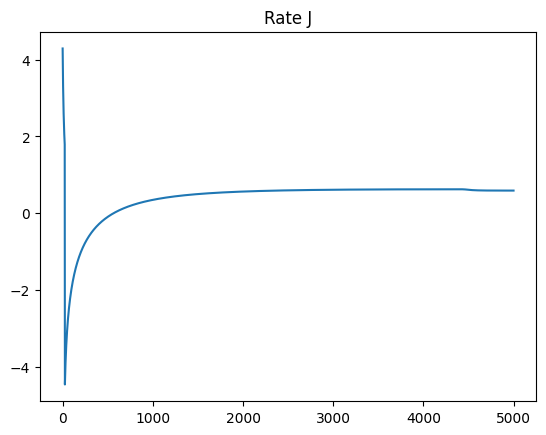

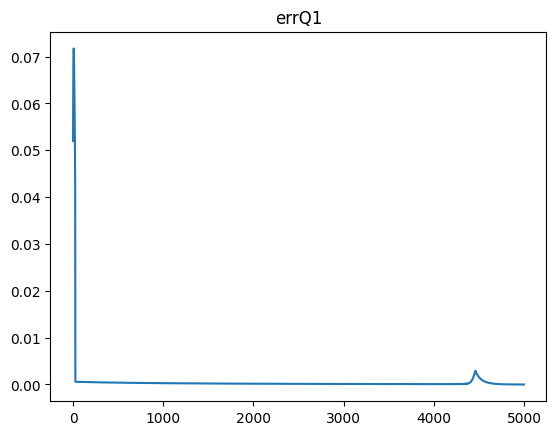

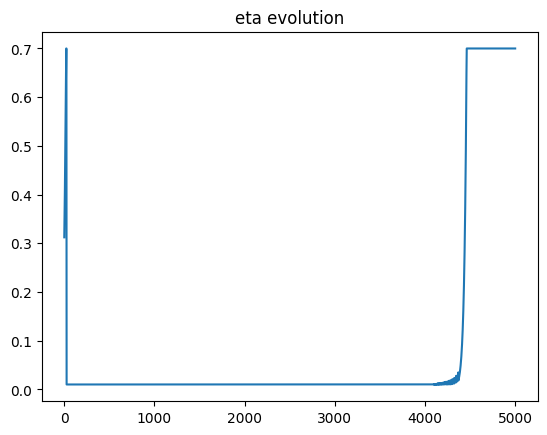

In [31]:
n1 = H1.shape[1]
Q1_init = (P1/n1) * np.eye(n1, dtype=complex)
# 参数准备
Q0, w0, Q1, n_it, hist = solve_game_bestresp_Q0_then_Q1(
    H0, H1, N0, 
    P0=P0, P1=P1,
    max_outer=5000, tol=1e-6, inner_Q1_steps=4,
    geometry='entropy',      # 'euclidean' → Extragradient; 'entropy' → Mirror-Prox
    step_rule='adp-eta',         # 'fixed' → 固定步长; 'adp-eta' → 自适应步长
    eta=0.5,                   # 仅在 step_rule='fixed' 时使用
    eta_init=0.3,              # 自适应时的初始步长
    eta_min=1e-2, eta_max=0.7, # 自适应时的步长范围
    beta=0.5, gamma=1.01,       # backtracking 收缩/扩张参数
    multi_stream=True,         # 用户水填充分配模式
    verbose=True,              # 打印每次迭代
    track_hist=True,            # 记录历史曲线
    Q1_init = Q1_init
)

# 查看收敛过程
import matplotlib.pyplot as plt
plt.plot(hist['J']); plt.title("Rate J"); plt.show()
plt.plot(hist['errQ1']); plt.title("errQ1"); plt.show()
plt.plot(hist['eta']); plt.title("eta evolution"); plt.show()


In [21]:
import numpy as np
from numpy.linalg import cholesky, solve, eigh

# ---------- numerics & helpers ----------
def hermitian(X): 
    return 0.5 * (X + X.conj().T)

def chol_inv_apply(A, B):
    M = A.shape[0]
    try:
        L = cholesky(A)
    except np.linalg.LinAlgError:
        eps = 1e-12 * np.trace(A).real / max(M,1)
        L = cholesky(A + eps*np.eye(M, dtype=complex))
    Y = solve(L, B)
    return solve(L.conj().T, Y)

# objective & grads
def gradients(H0, H1, Q0, Q1, N0):
    M = H0.shape[0]
    P = N0*np.eye(M, dtype=complex) + H1 @ Q1 @ H1.conj().T
    S = H0 @ Q0 @ H0.conj().T
    Ainv = chol_inv_apply(P + S, np.eye(M, dtype=complex))
    Pinv = chol_inv_apply(P,       np.eye(M, dtype=complex))
    G0 = hermitian(H0.conj().T @ Ainv @ H0)               # ascent
    G1 = hermitian(H1.conj().T @ (Ainv - Pinv) @ H1)      # descent
    return G0, G1

def compute_J(H0, H1, Q0, Q1, N0):
    M = H0.shape[0]
    P = N0*np.eye(M, dtype=complex) + H1 @ Q1 @ H1.conj().T
    S = H0 @ Q0 @ H0.conj().T
    A = P + S
    def ld(mat):
        try:
            L = cholesky(mat)
        except np.linalg.LinAlgError:
            eps = 1e-12*np.trace(mat).real/max(M,1)
            L = cholesky(mat + eps*np.eye(M, dtype=complex))
        return 2.0*np.sum(np.log(np.abs(np.diag(L))))
    return (ld(A) - ld(P))/np.log(2.0)

# ---------- entropic mirror (matrix log/exp) ----------
def _safe_floor(X):
    n = X.shape[0]
    # 按迹规模设置 log 的地板，避免非常小的特征值导致爆炸
    return 1e-10 * max(np.trace(hermitian(X)).real, 1.0) / max(n, 1)

def logm_psd(X, eps_floor=None):
    Xh = hermitian(X)
    lam, U = eigh(Xh)  # ascending
    if eps_floor is None:
        eps_floor = _safe_floor(Xh)
    lam = np.maximum(lam, eps_floor)
    return U @ np.diag(np.log(lam)) @ U.conj().T

def expm_herm_centered(Y):
    """
    数值更稳：exp(Y) = U diag(exp(lam - m)) U^H * exp(m)
    返回：X = exp(Y)/exp(m)（未归一迹）与标量 exp(m)
    """
    Yh = hermitian(Y)
    lam, U = eigh(Yh)
    m = float(np.max(lam))
    e = np.exp(lam - m)
    X = U @ np.diag(e) @ U.conj().T
    return X, np.exp(m)

def normalize_trace_to(X, tau):
    t = np.trace(X).real
    if t <= 0:
        n = X.shape[0]
        return tau * np.eye(n, dtype=complex) / n
    return (tau / t) * X

def entropic_proj_from_dual(Y, tau):
    # 先做中心化指数，再做等迹归一
    Xshift, scale = expm_herm_centered(Y)
    X = normalize_trace_to(Xshift, tau)
    return hermitian(X)

# ---------- stationarity residual (entropic mirror) ----------
def stationarity_residual_mirror(H0, H1, Q0, Q1, N0, P0, P1, eta_probe=0.2):
    G0, G1 = gradients(H0, H1, Q0, Q1, N0)
    L0, L1  = logm_psd(Q0), logm_psd(Q1)
    Q0p = entropic_proj_from_dual(L0 + eta_probe*G0, P0)   # ascent
    Q1p = entropic_proj_from_dual(L1 - eta_probe*G1, P1)   # descent
    return max(np.linalg.norm(Q0p - Q0, 'fro'),
               np.linalg.norm(Q1p - Q1, 'fro'))

# ---------- Mirror-Prox (Nemirovski) with adaptive eta ----------
def solve_game_mirror_prox(
    H0, H1, N0, P0, P1,
    steps=3000,
    eta=0.25,                   # 固定步长（对数域）
    step_rule='fixed',          # 固定步长：不做自适应
    beta=0.7, gamma=1.03,       # 仅 adp 会用；fixed 下忽略
    eta_min=1e-3, eta_max=1.0,  # 仅 adp 会用；fixed 下忽略
    tol=1e-6, min_steps=15,
    strong_reg=0.0,             # ascent: +μQ0, descent: -μQ1
    Q0_init=None, Q1_init=None,
    use_averaging=True,         # 后段平均
    eta_probe=0.2,              # residual 测温
    verbose=False, track_hist=True
):
    """
    固定步长 Mirror-Prox（熵镜像，等迹 tr(Q)=P）。
    依赖: hermitian, gradients, compute_J, logm_psd, entropic_proj_from_dual, stationarity_residual_mirror
    返回: (Q0, Q1, hist) 其中 hist 含 J / errQ0 / errQ1 / residual / eta / trQ0 / trQ1
    """
    n = H0.shape[1]
    Q0 = (P0/n) * np.eye(n, dtype=complex) if Q0_init is None else hermitian(Q0_init)
    Q1 = (P1/n) * np.eye(n, dtype=complex) if Q1_init is None else hermitian(Q1_init)

    hist = {'J': [], 'errQ0': [], 'errQ1': [], 'residual': [], 'eta': [],
            'trQ0': [], 'trQ1': []} if track_hist else None

    # averaging
    Q0_acc = np.zeros_like(Q0); Q1_acc = np.zeros_like(Q1); acc_cnt = 0
    burn_in = steps // 3

    # 初始残差（仅用于打印/早停判断）
    res_prev = stationarity_residual_mirror(H0, H1, Q0, Q1, N0, P0, P1, eta_probe=eta_probe)

    for k in range(1, steps+1):
        Q0 = hermitian(Q0); Q1 = hermitian(Q1)
        Q0_old = Q0.copy(); Q1_old = Q1.copy()

        # ---- predictor（dual/log 域）----
        G0, G1 = gradients(H0, H1, Q0, Q1, N0)
        if strong_reg > 0:
            G0 = G0 + strong_reg*Q0      # ascent 端：+μQ0
            G1 = G1 - strong_reg*Q1      # descent 端：-μQ1

        L0, L1  = logm_psd(Q0), logm_psd(Q1)
        Q0_half = entropic_proj_from_dual(L0 + eta*G0, P0)
        Q1_half = entropic_proj_from_dual(L1 - eta*G1, P1)

        # ---- corrector ----
        G0h, G1h = gradients(H0, H1, Q0_half, Q1_half, N0)
        if strong_reg > 0:
            G0h = G0h + strong_reg*Q0_half
            G1h = G1h - strong_reg*Q1_half

        # 固定步长：直接用 eta，不做回溯/自适应
        Q0_new = entropic_proj_from_dual(L0 + eta*G0h, P0)
        Q1_new = entropic_proj_from_dual(L1 - eta*G1h, P1)

        # ---- 记录指标 ----
        errQ0 = np.linalg.norm(Q0_new - Q0_old, 'fro') / max(np.linalg.norm(Q0_old,'fro'), 1.0)
        errQ1 = np.linalg.norm(Q1_new - Q1_old, 'fro') / max(np.linalg.norm(Q1_old,'fro'), 1.0)
        Jval  = compute_J(H0, H1, Q0_new, Q1_new, N0)
        res   = stationarity_residual_mirror(H0, H1, Q0_new, Q1_new, N0, P0, P1, eta_probe=eta)

        if track_hist:
            hist['J'].append(Jval)
            hist['errQ0'].append(errQ0); hist['errQ1'].append(errQ1)
            hist['residual'].append(res); hist['eta'].append(eta)
            hist['trQ0'].append(np.trace(Q0_new).real); hist['trQ1'].append(np.trace(Q1_new).real)

        if verbose and (k <= 10 or k % 50 == 0 or k == steps):
            print(f"[{k:04d}] J={Jval:.4f}, errQ0={errQ0:.2e}, errQ1={errQ1:.2e}, "
                  f"res={res:.2e}, eta={eta:.3g}, trQ0={hist['trQ0'][-1]:.5f}, trQ1={hist['trQ1'][-1]:.5f}")

        # averaging（后 2/3 轮开始）
        if use_averaging and k >= burn_in:
            Q0_acc += Q0_new; Q1_acc += Q1_new; acc_cnt += 1

        Q0, Q1 = Q0_new, Q1_new
        res_prev = res

        # 早停
        if (k >= min_steps) and (max(errQ0, errQ1) < tol) and (res < max(1e-3*tol, tol)):
            break

    # 输出平均解（若启用）
    if use_averaging and acc_cnt > 0:
        Q0_out = hermitian(Q0_acc/acc_cnt); Q1_out = hermitian(Q1_acc/acc_cnt)
    else:
        Q0_out, Q1_out = Q0, Q1

    return (Q0_out, Q1_out, hist) if track_hist else (Q0_out, Q1_out)



In [22]:
# 热启动（可选）
n1 = H1.shape[1]
Q1_init = (P1/n1) * np.eye(n1, dtype=complex)

Q0_mp, Q1_mp, hist_mp = solve_game_mirror_prox(
    H0, H1, N0, P0, P1,
    steps=10000,
    eta=0.25,                 # 可试 0.2~0.4
    step_rule='adp',          # 自适应更快；不稳再换 fixed
    beta=0.7, gamma=1.03,     # 温和放大/缩小
    eta_min=1e-3, eta_max=1.0,
    strong_reg=0.0,           # 不稳时再开 1e-3
    Q0_init=None, Q1_init=Q1_init,
    use_averaging=True,
    eta_probe=0.2,
    verbose=True, track_hist=True
)



# Q0_mp, Q1_mp, hist_mp = solve_game_mirror_prox(
#     H0, H1, N0, P0, P1,
#     steps=5000,
#     eta=0.25,                 # 固定；不自适应
#     step_rule='fixed',        # 关键：固定步长
#     strong_reg=0.0,           # 不稳再设 1e-3
#     Q0_init=None, Q1_init=Q1_init,
#     use_averaging=True,
#     eta_probe=0.2,
#     verbose=True, track_hist=True
# )



[0001] J=0.6489, errQ0=1.23e-02, errQ1=9.97e-03, res=3.99e-01, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0002] J=0.9328, errQ0=1.97e-02, errQ1=1.01e-02, res=3.46e-01, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0003] J=1.3185, errQ0=3.22e-02, errQ1=1.01e-02, res=2.89e-01, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0004] J=1.7984, errQ0=5.24e-02, errQ1=1.01e-02, res=2.37e-01, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0005] J=2.3094, errQ0=7.80e-02, errQ1=1.01e-02, res=1.91e-01, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0006] J=2.7605, errQ0=9.72e-02, errQ1=1.04e-02, res=1.53e-01, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0007] J=3.1045, errQ0=1.01e-01, errQ1=1.06e-02, res=1.38e-01, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0008] J=3.3473, errQ0=9.18e-02, errQ1=1.09e-02, res=1.43e-01, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0009] J=3.5122, errQ0=7.75e-02, errQ1=1.12e-02, res=1.47e-01, eta=0.25, trQ0=1.00000, trQ1=100.00000
[0010] J=3.6210, errQ0=6.25e-02, errQ1=1.14e-02, res=1.50e-01, eta=0.25, trQ0=1.00

In [45]:
import numpy as np
from numpy.linalg import cholesky, solve, eigh

# ---------------- helpers ----------------
def hermitian(X): return 0.5*(X + X.conj().T)

def chol_inv_apply(A, B):
    M = A.shape[0]
    try:
        L = cholesky(A)
    except np.linalg.LinAlgError:
        eps = 1e-12 * np.trace(A).real / max(M,1)
        L = cholesky(A + eps*np.eye(M, dtype=complex))
    Y = solve(L, B)
    return solve(L.conj().T, Y)

def proj_psd_trace_le(Z, tau, eps_floor=0.0):
    Zh = hermitian(Z)
    lam, U = eigh(Zh)                 # 升序
    lam = np.maximum(lam, eps_floor)
    s = lam.sum()
    if s <= tau + 1e-12:
        return hermitian(U @ np.diag(lam) @ U.conj().T)
    lam_desc = lam[::-1]
    csum = np.cumsum(lam_desc)
    idx = np.nonzero(lam_desc - (csum - tau) / (np.arange(1, lam_desc.size+1)) > 0)[0]
    if len(idx) == 0:
        theta = (csum[-1] - tau) / lam_desc.size
        lam_desc = np.maximum(lam_desc - theta, 0.0)
    else:
        r = idx[-1] + 1
        theta = (csum[r-1] - tau) / r
        lam_desc = np.maximum(lam_desc - theta, 0.0)
    lam = lam_desc[::-1]
    return hermitian(U @ np.diag(lam) @ U.conj().T)

def proj_psd_trace_eq(Z, tau, eps_floor=0.0):
    Zh = hermitian(Z)
    lam, U = eigh(Zh)                 # 升序
    lam = np.maximum(lam, eps_floor)
    s = lam[::-1]
    lo, hi = s[-1] - abs(tau), s[0] + abs(tau)
    for _ in range(80):
        mid = 0.5*(lo+hi)
        x = np.maximum(0.0, s - mid)
        if x.sum() > tau: lo = mid
        else:             hi = mid
    x = np.maximum(0.0, s - hi)
    x = x[::-1]
    return hermitian(U @ np.diag(x) @ U.conj().T)

# ---------------- objective & grads ----------------
def gradients(H0, H1, Q0, Q1, N0):
    M = H0.shape[0]
    P = N0*np.eye(M, dtype=complex) + H1 @ Q1 @ H1.conj().T
    S = H0 @ Q0 @ H0.conj().T
    Ainv = chol_inv_apply(P + S, np.eye(M, dtype=complex))
    Pinv = chol_inv_apply(P,       np.eye(M, dtype=complex))
    G0 = hermitian(H0.conj().T @ Ainv @ H0)
    G1 = hermitian(H1.conj().T @ (Ainv - Pinv) @ H1)
    return G0, G1

def compute_J(H0, H1, Q0, Q1, N0):
    M = H0.shape[0]
    P = N0*np.eye(M, dtype=complex) + H1 @ Q1 @ H1.conj().T
    S = H0 @ Q0 @ H0.conj().T
    A = P + S
    def ld(mat):
        try:
            L = cholesky(mat)
        except np.linalg.LinAlgError:
            eps = 1e-12*np.trace(mat).real/max(M,1)
            L = cholesky(mat + eps*np.eye(M, dtype=complex))
        return 2.0*np.sum(np.log(np.abs(np.diag(L))))
    return (ld(A) - ld(P))/np.log(2.0)

# ---------------- residual (gradient mapping) ----------------
def kkt_residual_proj(H0, H1, Q0, Q1, N0, P0, P1,
                      eta_probe=0.2,
                      mode='eq'):  # 'eq' | 'le' | 'both'
    """
    mode='eq'  ：residual 使用等迹投影（推荐做“测温”）
    mode='le'  ：residual 使用 ≤ 投影
    mode='both'：同时返回(res_eq, res_le)
    """
    # G
    G0, G1 = gradients(H0, H1, Q0, Q1, N0)

    # ≤ 残差
    Q0p_le = proj_psd_trace_le(Q0 + eta_probe*G0, P0)
    Q1p_le = proj_psd_trace_le(Q1 - eta_probe*G1, P1)
    R0_le  = (Q0p_le - Q0) / eta_probe
    R1_le  = (Q1p_le - Q1) / eta_probe
    res_le = max(np.linalg.norm(R0_le,'fro'), np.linalg.norm(R1_le,'fro'))

    # = 残差
    Q0p_eq = proj_psd_trace_eq(Q0 + eta_probe*G0, P0)
    Q1p_eq = proj_psd_trace_eq(Q1 - eta_probe*G1, P1)
    R0_eq  = (Q0p_eq - Q0) / eta_probe
    R1_eq  = (Q1p_eq - Q1) / eta_probe
    res_eq = max(np.linalg.norm(R0_eq,'fro'), np.linalg.norm(R1_eq,'fro'))

    if mode == 'both': return res_eq, res_le
    return res_eq if mode == 'eq' else res_le

# ---------------- Extragradient（热启动 + 非单调自适应 + 可选残差） ----------------
def solve_game_extragradient(
    H0, H1, N0, P0, P1,
    steps=3000,
    eta=0.25,
    step_rule='fixed',              # 'fixed' | 'adp_res' | 'adp_bal'
    beta=0.7, gamma=1.02,           # 缩步 / 温和放大
    eta_min=1e-3, eta_max=1.0,
    tol=1e-6, min_steps=10,
    strong_reg=0.0,                 # ascent: -μQ0, descent: +μQ1
    equal_trace=False,              # 仅影响“更新”；推荐 False(≤)
    eta_probe=0.2,                  # residual “测温”步长
    Q0_init=None, Q1_init=None,     # 热启动
    residual_ref='eq',              # 'eq' | 'le' | 'both'（自适应用哪一个）
    window=10,                      # 非单调窗口
    boost_period=10,                # 周期性温和放大
    verbose=False, track_hist=True
):
    proj = proj_psd_trace_eq if equal_trace else proj_psd_trace_le
    N = H0.shape[1]
    Q0 = (np.zeros((N,N), complex) if Q0_init is None else hermitian(Q0_init.copy()))
    Q1 = (np.zeros((N,N), complex) if Q1_init is None else hermitian(Q1_init.copy()))

    if track_hist:
        hist = {'J': [], 'errQ0': [], 'errQ1': [], 'residual': [], 'res_eq': [], 'res_le': [],
                'eta': [], 'trQ0': [], 'trQ1': []}
    else:
        hist = None

    # 初值残差（用于外层自适应与回溯门限）
    if residual_ref == 'both':
        res_eq0, res_le0 = kkt_residual_proj(H0,H1,Q0,Q1,N0,P0,P1,eta_probe,mode='both')
        res_prev = res_eq0  # 自适应仍以 res_eq 引导
    else:
        res_prev = kkt_residual_proj(H0,H1,Q0,Q1,N0,P0,P1,eta_probe,mode=residual_ref)

    res_buf = [res_prev]
    J_prev   = compute_J(H0, H1, Q0, Q1, N0)

    for k in range(1, steps+1):
        Q0 = hermitian(Q0); Q1 = hermitian(Q1)
        Q0_old = Q0.copy(); Q1_old = Q1.copy()

        # ---------- predict ----------
        G0, G1 = gradients(H0, H1, Q0, Q1, N0)
        if strong_reg > 0:
            G0 = G0 - strong_reg*Q0
            G1 = G1 + strong_reg*Q1
        Q0_half = proj(Q0 + eta*G0, P0)
        Q1_half = proj(Q1 - eta*G1, P1)

        # ---------- correct ----------
        G0h, G1h = gradients(H0, H1, Q0_half, Q1_half, N0)
        if strong_reg > 0:
            G0h = G0h - strong_reg*Q0_half
            G1h = G1h + strong_reg*Q1_half

        # ---------- 内回溯（非单调窗口） ----------
        eta_try = float(eta)
        accept  = False
        res_ref_threshold = max(res_buf)  # 允许非单调，但不要超过窗口上界
        for _ in range(15):
            Q0_new = proj(Q0 + eta_try*G0h, P0)
            Q1_new = proj(Q1 - eta_try*G1h, P1)

            if residual_ref == 'both':
                res_eq, res_le = kkt_residual_proj(H0,H1,Q0_new,Q1_new,N0,P0,P1,eta_probe,mode='both')
                res_new = res_eq  # 仍用等迹残差做判据
            else:
                res_new = kkt_residual_proj(H0,H1,Q0_new,Q1_new,N0,P0,P1,eta_probe,mode=residual_ref)

            if (step_rule == 'fixed') or (res_new <= res_ref_threshold + 1e-12):
                accept = True
                break
            eta_try = max(eta_min, eta_try*beta)

        if not accept:
            # 防卡死：接受最后一次
            Q0_new = proj(Q0 + eta_try*G0h, P0)
            Q1_new = proj(Q1 - eta_try*G1h, P1)
            if residual_ref == 'both':
                res_eq, res_le = kkt_residual_proj(H0,H1,Q0_new,Q1_new,N0,P0,P1,eta_probe,mode='both')
                res_new = res_eq
            else:
                res_new = kkt_residual_proj(H0,H1,Q0_new,Q1_new,N0,P0,P1,eta_probe,mode=residual_ref)

        # ---------- 指标 ----------
        errQ0 = np.linalg.norm(Q0_new - Q0_old, 'fro') / max(np.linalg.norm(Q0_old,'fro'), 1.0)
        errQ1 = np.linalg.norm(Q1_new - Q1_old, 'fro') / max(np.linalg.norm(Q1_old,'fro'), 1.0)
        Jval  = compute_J(H0, H1, Q0_new, Q1_new, N0)

        # 如需同时记录两种残差
        if residual_ref == 'both':
            res_eq, res_le = kkt_residual_proj(H0,H1,Q0_new,Q1_new,N0,P0,P1,eta_probe,mode='both')
            if track_hist:
                hist['res_eq'].append(res_eq); hist['res_le'].append(res_le)
        if track_hist:
            hist['J'].append(Jval)
            hist['errQ0'].append(errQ0); hist['errQ1'].append(errQ1)
            hist['residual'].append(res_new); hist['eta'].append(eta_try)
            hist['trQ0'].append(np.trace(Q0_new).real); hist['trQ1'].append(np.trace(Q1_new).real)

        if verbose and (k <= 10 or k % 50 == 0 or k == steps):
            if residual_ref == 'both':
                print(f"[{k:04d}] J={Jval:.4f}, errQ0={errQ0:.2e}, errQ1={errQ1:.2e}, "
                      f"res_eq={hist['res_eq'][-1]:.2e}, res_le={hist['res_le'][-1]:.2e}, "
                      f"eta={eta_try:.3g}, trQ0={hist['trQ0'][-1]:.5f}, trQ1={hist['trQ1'][-1]:.5f}")
            else:
                print(f"[{k:04d}] J={Jval:.4f}, errQ0={errQ0:.2e}, errQ1={errQ1:.2e}, "
                      f"res={res_new:.2e}, eta={eta_try:.3g}, trQ0={hist['trQ0'][-1]:.5f}, trQ1={hist['trQ1'][-1]:.5f}")

        # ---------- 外层自适应 ----------
        if step_rule in ('adp_res', 'adp_bal'):
            res_buf.append(res_new)
            if len(res_buf) > window:
                res_buf.pop(0)
            if (k % boost_period) == 0:
                if res_new <= min(res_buf) * 0.995:   # 有实质改善
                    eta = min(eta_max, eta * gamma)
                else:
                    eta = max(eta_min, eta * beta)

        # 更新
        Q0, Q1 = hermitian(Q0_new), hermitian(Q1_new)
        res_prev, J_prev = res_new, Jval

        # 停止
        if (k >= min_steps) and (max(errQ0, errQ1) < tol) and (res_new < max(1e-3*tol, tol)):
            break

    return (Q0, Q1, hist) if track_hist else (Q0, Q1)


In [ ]:
# Jammer 满功率热启动（Tr ≤ P1 的可行域上，常见最优在满功率边界）
N1 = H1.shape[1]
Q1_init = (P1 / N1) * np.eye(N1, dtype=complex)
# Q1_init = None


# Q0_eg, Q1_eg, hist_eg = solve_game_extragradient(
#     H0, H1, N0, P0, P1,
#     steps=5000, eta=0.35,
#     step_rule='fixed',
#     strong_reg=0.0,
#     equal_trace=False,      # 更新用 ≤
#     eta_probe=0.05,         # 小一点更稳
#     Q1_init=Q1_init,        # 热启动（可选）
#     residual_ref='eq',      # ★ 残差用等迹
#     verbose=True, track_hist=True
# )

Q0_eg, Q1_eg, hist_eg = solve_game_extragradient(
    H0, H1, N0, P0, P1,
    steps=5000, eta=0.35,
    step_rule='adp_res', beta=0.6, gamma=1.03,
    eta_min=0.1, eta_max=0.8,
    equal_trace=False,
    eta_probe=0.05,
    Q1_init=Q1_init,
    residual_ref='eq',    # ★ 选择both可以记录 res_eq 与 res_le
    verbose=True, track_hist=True
)



[0001] J=4.8452, errQ0=8.71e-01, errQ1=2.41e-03, res=4.10e+00, eta=0.21, trQ0=1.00000, trQ1=100.00000
[0002] J=2.4549, errQ0=1.86e-01, errQ1=1.08e-03, res=2.72e+01, eta=0.1, trQ0=1.00000, trQ1=100.00000
[0003] J=2.4531, errQ0=1.87e-03, errQ1=3.85e-03, res=2.70e+01, eta=0.35, trQ0=1.00000, trQ1=100.00000
[0004] J=2.4515, errQ0=1.60e-03, errQ1=3.73e-03, res=2.68e+01, eta=0.35, trQ0=1.00000, trQ1=100.00000
[0005] J=2.4501, errQ0=1.50e-03, errQ1=3.62e-03, res=2.66e+01, eta=0.35, trQ0=1.00000, trQ1=100.00000
[0006] J=2.4488, errQ0=1.42e-03, errQ1=3.51e-03, res=2.65e+01, eta=0.35, trQ0=1.00000, trQ1=100.00000
[0007] J=2.4476, errQ0=1.34e-03, errQ1=3.42e-03, res=2.63e+01, eta=0.35, trQ0=1.00000, trQ1=100.00000
[0008] J=2.4465, errQ0=1.28e-03, errQ1=3.33e-03, res=2.62e+01, eta=0.35, trQ0=1.00000, trQ1=100.00000
[0009] J=2.4455, errQ0=1.22e-03, errQ1=3.24e-03, res=2.61e+01, eta=0.35, trQ0=1.00000, trQ1=100.00000
[0010] J=2.4446, errQ0=1.17e-03, errQ1=3.17e-03, res=2.59e+01, eta=0.35, trQ0=1.000

In [12]:
import numpy as np
from numpy.linalg import cholesky, solve, eigh

# ---------- helpers ----------
def hermitian(X): return 0.5*(X + X.conj().T)

def chol_inv_apply(A, B):
    M = A.shape[0]
    try:
        L = cholesky(A)
    except np.linalg.LinAlgError:
        eps = 1e-12 * np.trace(A).real / max(M,1)
        L = cholesky(A + eps*np.eye(M, dtype=complex))
    Y = solve(L, B)
    return solve(L.conj().T, Y)

# ---------- J & grads ----------
def gradients(H0, H1, Q0, Q1, N0):
    M = H0.shape[0]
    P = N0*np.eye(M, dtype=complex) + H1 @ Q1 @ H1.conj().T
    S = H0 @ Q0 @ H0.conj().T
    Ainv = chol_inv_apply(P + S, np.eye(M, dtype=complex))
    Pinv = chol_inv_apply(P,       np.eye(M, dtype=complex))
    G0 = hermitian(H0.conj().T @ Ainv @ H0)
    G1 = hermitian(H1.conj().T @ (Ainv - Pinv) @ H1)
    return G0, G1

def compute_J(H0, H1, Q0, Q1, N0):
    M = H0.shape[0]
    P = N0*np.eye(M, dtype=complex) + H1 @ Q1 @ H1.conj().T
    S = H0 @ Q0 @ H0.conj().T
    A = P + S
    def ld(mat):
        try:
            L = cholesky(mat)
        except np.linalg.LinAlgError:
            eps = 1e-12*np.trace(mat).real/M
            L = cholesky(mat + eps*np.eye(M, dtype=complex))
        return 2.0*np.sum(np.log(np.abs(np.diag(L))))
    return (ld(A) - ld(P))/np.log(2.0)

# ---------- PSD + trace ≤ tau ----------
def proj_psd_trace_le(Z, tau, eps_floor=0.0):
    """
    Frobenius 投影到 {Q ⪰ eps_floor*I, tr(Q) ≤ tau}.
    若 Tr(PSD(Z)) ≤ tau 直接返回；否则做等迹(simplex)到 sum = tau。
    """
    Zh = hermitian(Z)
    lam, U = eigh(Zh)                 # 升序
    lam = np.maximum(lam, eps_floor)
    s = lam.sum()
    if s <= tau + 1e-12:
        return hermitian(U @ np.diag(lam) @ U.conj().T)
    # 投到 simplex: sum = tau
    lam_desc = lam[::-1]
    csum = np.cumsum(lam_desc)
    rho_idx = np.nonzero(lam_desc - (csum - tau) / (np.arange(1, lam_desc.size+1)) > 0)[0]
    if len(rho_idx) == 0:
        theta = (csum[-1] - tau) / lam_desc.size
        lam_desc = np.maximum(lam_desc - theta, 0.0)
    else:
        r = rho_idx[-1] + 1
        theta = (csum[r-1] - tau) / r
        lam_desc = np.maximum(lam_desc - theta, 0.0)
    lam = lam_desc[::-1]
    return hermitian(U @ np.diag(lam) @ U.conj().T)

# ---------- residual: gradient mapping (≤-projection, scaled by eta_probe) ----------
def kkt_residual_le(H0, H1, Q0, Q1, N0, P0, P1, eta_probe=0.2):
    """
    R0 = (Proj_≤(Q0 + eta*G0) - Q0)/eta,  R1 = (Proj_≤(Q1 - eta*G1) - Q1)/eta
    返回 max(||R0||_F, ||R1||_F)
    """
    G0, G1 = gradients(H0, H1, Q0, Q1, N0)
    Q0p = proj_psd_trace_le(Q0 + eta_probe*G0, P0)
    Q1p = proj_psd_trace_le(Q1 - eta_probe*G1, P1)
    R0  = (Q0p - Q0) / eta_probe
    R1  = (Q1p - Q1) / eta_probe
    return max(np.linalg.norm(R0, 'fro'), np.linalg.norm(R1, 'fro'))

# ---------- Proximal Best-Response（自适应 eta：回溯+温和放大） ----------
def _proxBR_Q0(H0, H1, Q0k, Q1k, N0, P0, rho,
               inner_max=200, inner_tol=1e-6,
               eta0=0.25, beta=0.5, gamma=1.1, eta_min=1e-3, eta_max=1.0):
    """
    上升方（用户）prox-BR：f(Q0) = J(Q0,Q1k) - (rho/2)||Q0-Q0k||^2
    回溯判据：f_new >= f_old - eps
    """
    Q0 = Q0k.copy()
    eta = float(eta0)
    f_old = compute_J(H0, H1, Q0, Q1k, N0) - 0.5*rho*np.linalg.norm(Q0-Q0k,'fro')**2
    for _ in range(inner_max):
        G0, _ = gradients(H0, H1, Q0, Q1k, N0)
        grad  = G0 - rho*(Q0 - Q0k)                # 上升梯度
        # backtracking
        tried = False
        for __ in range(20):
            Q0_new = proj_psd_trace_le(Q0 + eta*grad, P0)
            f_new = compute_J(H0, H1, Q0_new, Q1k, N0) - 0.5*rho*np.linalg.norm(Q0_new-Q0k,'fro')**2
            if f_new + 1e-12 >= f_old:             # 成功：接受并尝试温和放大
                tried = True
                if np.linalg.norm(Q0_new - Q0, 'fro') < inner_tol:
                    Q0 = Q0_new
                    return Q0
                Q0, f_old = Q0_new, f_new
                eta = min(max(eta*gamma, eta_min), eta_max)
                break
            eta = max(eta*beta, eta_min)           # 缩步
        if not tried:
            # 回溯穷尽也未通过：接受最后一次
            Q0 = Q0_new
            break
    return hermitian(Q0)

def _proxBR_Q1(H0, H1, Q0k1, Q1k, N0, P1, rho,
               inner_max=200, inner_tol=1e-6,
               eta0=0.25, beta=0.5, gamma=1.1, eta_min=1e-3, eta_max=1.0):
    """
    下降方（干扰）prox-BR：g(Q1) = J(Q0k1,Q1) + (rho/2)||Q1-Q1k||^2
    回溯判据：g_new <= g_old + eps
    """
    Q1 = Q1k.copy()
    eta = float(eta0)
    g_old = compute_J(H0, H1, Q0k1, Q1, N0) + 0.5*rho*np.linalg.norm(Q1-Q1k,'fro')**2
    for _ in range(inner_max):
        _, G1 = gradients(H0, H1, Q0k1, Q1, N0)
        grad  = G1 + rho*(Q1 - Q1k)                # 下降梯度
        # backtracking
        tried = False
        for __ in range(20):
            Q1_new = proj_psd_trace_le(Q1 - eta*grad, P1)
            g_new = compute_J(H0, H1, Q0k1, Q1_new, N0) + 0.5*rho*np.linalg.norm(Q1_new-Q1k,'fro')**2
            if g_new <= g_old + 1e-12:             # 成功：接受并尝试温和放大
                tried = True
                if np.linalg.norm(Q1_new - Q1, 'fro') < inner_tol:
                    Q1 = Q1_new
                    return Q1
                Q1, g_old = Q1_new, g_new
                eta = min(max(eta*gamma, eta_min), eta_max)
                break
            eta = max(eta*beta, eta_min)
        if not tried:
            Q1 = Q1_new
            break
    return hermitian(Q1)

# ---------- 外层求解器（返回 errQ0 / errQ1 + residual） ----------
def solve_game_proxBR(
    H0, H1, N0, P0, P1,
    rho=1e-2,
    outer_steps=300, outer_tol=1e-6,
    inner_max=200, inner_tol=1e-6,
    eta0_inner=0.25, beta=0.5, gamma=1.1, eta_min=1e-3, eta_max=1.0,
    Q0_init=None, Q1_init=None,
    eta_probe=0.2, min_outer=5,
    verbose=True, track_hist=True
):
    """
    Proximal Best-Response，Tr ≤ 约束；内层 eta 自适应（回溯 + 温和放大）。
    返回 Q0, Q1, hist（含 J / errQ0 / errQ1 / residual / trQ0 / trQ1）
    """
    N = H0.shape[1]
    Q0 = np.zeros((N, N), dtype=complex) if Q0_init is None else Q0_init.copy()
    Q1 = np.zeros((N, N), dtype=complex) if Q1_init is None else Q1_init.copy()
    hist = {'J': [], 'errQ0': [], 'errQ1': [], 'residual': [], 'trQ0': [], 'trQ1': []} if track_hist else None

    for k in range(1, outer_steps+1):
        Q0 = hermitian(Q0); Q1 = hermitian(Q1)
        Q0_old = Q0.copy(); Q1_old = Q1.copy()

        # 内层：先 user，再 jammer；各自都有回溯&放大
        Q0_new = _proxBR_Q0(H0, H1, Q0, Q1, N0, P0, rho,
                            inner_max=inner_max, inner_tol=inner_tol,
                            eta0=eta0_inner, beta=beta, gamma=gamma,
                            eta_min=eta_min, eta_max=eta_max)
        Q1_new = _proxBR_Q1(H0, H1, Q0_new, Q1, N0, P1, rho,
                            inner_max=inner_max, inner_tol=inner_tol,
                            eta0=eta0_inner, beta=beta, gamma=gamma,
                            eta_min=eta_min, eta_max=eta_max)

        # 相对步长
        errQ0 = np.linalg.norm(Q0_new - Q0_old, 'fro') / max(np.linalg.norm(Q0_old, 'fro'), 1.0)
        errQ1 = np.linalg.norm(Q1_new - Q1_old, 'fro') / max(np.linalg.norm(Q1_old, 'fro'), 1.0)

        # 指标
        Jval = compute_J(H0, H1, Q0_new, Q1_new, N0)
        res  = kkt_residual_le(H0, H1, Q0_new, Q1_new, N0, P0, P1, eta_probe=eta_probe)

        if track_hist:
            hist['J'].append(Jval)
            hist['errQ0'].append(errQ0)
            hist['errQ1'].append(errQ1)
            hist['residual'].append(res)
            hist['trQ0'].append(np.trace(Q0_new).real)
            hist['trQ1'].append(np.trace(Q1_new).real)

        if verbose and (k % 10 == 0 or k <= 5 or k == outer_steps):
            print(f"[{k:03d}] J={Jval:.4f}, errQ0={errQ0:.2e}, errQ1={errQ1:.2e}, res={res:.2e}, trQ1={np.trace(Q1_new).real:.4f}")

        Q0, Q1 = Q0_new, Q1_new

        # 停止：err 与 residual 双达标，且防早停
        if (k >= min_outer) and (max(errQ0, errQ1) < outer_tol) and (res < max(1e-3*outer_tol, outer_tol)):
            break

    return (Q0, Q1, hist) if track_hist else (Q0, Q1)


[001] J=2.7961, errQ0=7.17e-01, errQ1=9.02e+00, res=5.27e-01, trQ1=12.8846
[002] J=2.4811, errQ0=5.11e-01, errQ1=5.61e-01, res=5.46e-02, trQ1=18.5790
[003] J=2.2224, errQ0=3.36e-02, errQ1=2.72e-01, res=4.17e-02, trQ1=22.7629
[004] J=2.0530, errQ0=1.13e-02, errQ1=1.77e-01, res=3.46e-02, trQ1=26.1867
[005] J=1.9294, errQ0=6.98e-03, errQ1=1.30e-01, res=3.00e-02, trQ1=29.1263
[010] J=1.5851, errQ0=1.69e-03, errQ1=5.40e-02, res=1.93e-02, trQ1=40.0640
[020] J=1.2947, errQ0=4.84e-04, errQ1=2.42e-02, res=1.25e-02, trQ1=54.3099
[030] J=1.1469, errQ0=2.49e-04, errQ1=1.54e-02, res=9.65e-03, trQ1=64.5327
[040] J=1.0512, errQ0=1.58e-04, errQ1=1.12e-02, res=8.04e-03, trQ1=72.7764
[050] J=0.9818, errQ0=1.11e-04, errQ1=8.81e-03, res=6.97e-03, trQ1=79.7984
[060] J=0.9282, errQ0=8.43e-05, errQ1=7.23e-03, res=6.21e-03, trQ1=85.9757
[070] J=0.8849, errQ0=6.67e-05, errQ1=6.13e-03, res=5.62e-03, trQ1=91.5271
[080] J=0.8489, errQ0=5.54e-05, errQ1=5.31e-03, res=5.16e-03, trQ1=96.5922
[090] J=0.8217, errQ0=1.2

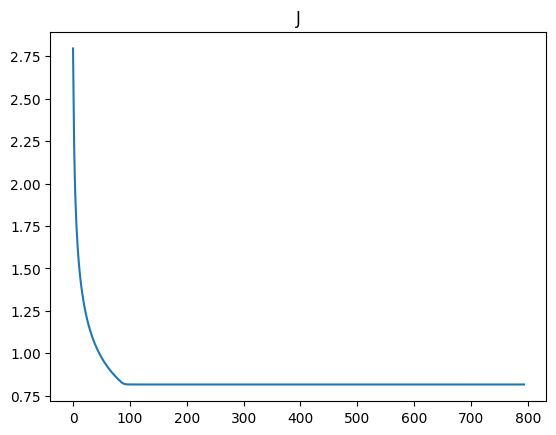

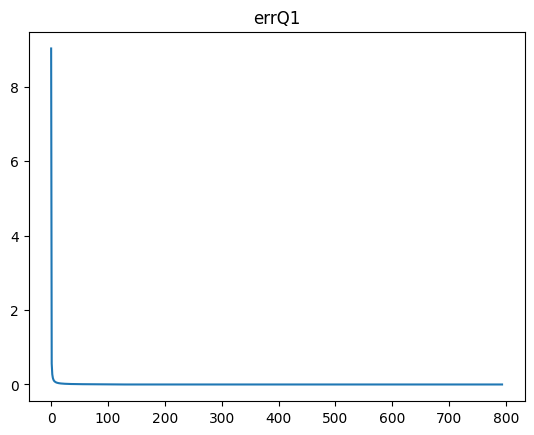

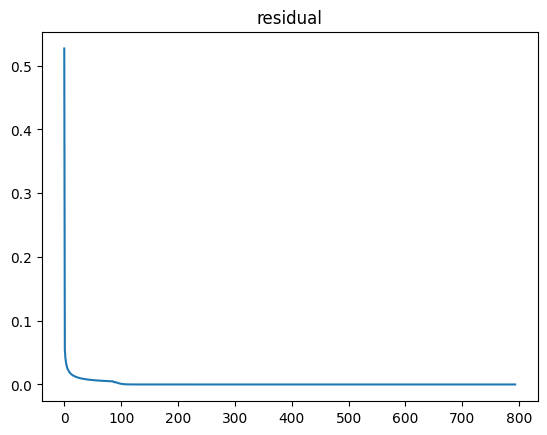

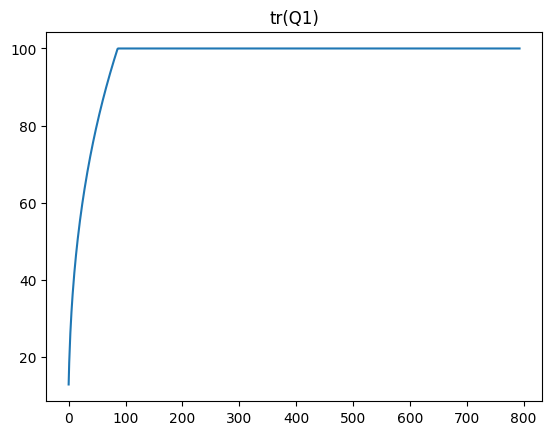

In [14]:
Q0, Q1, hist = solve_game_proxBR(
    H0, H1, N0, P0, P1,
    rho=1e-2,
    outer_steps=1000, outer_tol=1e-6,
    inner_max=200, inner_tol=1e-6,
    eta0_inner=0.5,         # 内层初始步长
    beta=0.5, gamma=1.1,     # 回溯收缩/温和放大
    eta_min=1e-2, eta_max=1.0,
    eta_probe=0.1,           # residual 的“测温”步长
    min_outer=5,             # 防第一轮早停
    verbose=True, track_hist=True
)


import matplotlib.pyplot as plt
plt.plot(hist['J']);        plt.title("J");         plt.show()
plt.plot(hist['errQ1']);    plt.title("errQ1");     plt.show()
plt.plot(hist['residual']); plt.title("residual");  plt.show()
plt.plot(hist['trQ1']);     plt.title("tr(Q1)");    plt.show()

In [28]:
import numpy as np
from numpy.linalg import cholesky, solve, eigh

# ===================== helpers =====================
def hermitian(X): return 0.5*(X + X.conj().T)

def chol_inv_apply(A, B):
    M = A.shape[0]
    try:
        L = cholesky(A)
    except np.linalg.LinAlgError:
        eps = 1e-12 * np.trace(A).real / max(M,1)
        L = cholesky(A + eps*np.eye(M, dtype=complex))
    Y = solve(L, B)
    return solve(L.conj().T, Y)

def proj_psd_trace_le(Z, tau, eps_floor=0.0):
    """Euclidean projection onto {Q ⪰ eps_floor*I, tr(Q) ≤ tau}."""
    Zh = hermitian(Z)
    lam, U = eigh(Zh)                # ascending
    lam = np.maximum(lam, eps_floor)
    s = lam.sum()
    if s <= tau + 1e-12:
        return hermitian(U @ np.diag(lam) @ U.conj().T)
    # simplex to sum=tau
    lam_desc = lam[::-1]
    csum = np.cumsum(lam_desc)
    idx = np.nonzero(lam_desc - (csum - tau) / (np.arange(1, lam_desc.size+1)) > 0)[0]
    if len(idx) == 0:
        theta = (csum[-1] - tau) / lam_desc.size
        lam_desc = np.maximum(lam_desc - theta, 0.0)
    else:
        r = idx[-1] + 1
        theta = (csum[r-1] - tau) / r
        lam_desc = np.maximum(lam_desc - theta, 0.0)
    lam = lam_desc[::-1]
    return hermitian(U @ np.diag(lam) @ U.conj().T)

# ===================== objective & grads =====================
def gradients(H0, H1, Q0, Q1, N0):
    """
    ∇_{Q0}J (ascent) and ∇_{Q1}J (descent); both Hermitian.
    """
    M = H0.shape[0]
    P = N0*np.eye(M, dtype=complex) + H1 @ Q1 @ H1.conj().T
    S = H0 @ Q0 @ H0.conj().T
    Ainv = chol_inv_apply(P + S, np.eye(M, dtype=complex))
    Pinv = chol_inv_apply(P,       np.eye(M, dtype=complex))
    G0 = hermitian(H0.conj().T @ Ainv @ H0)
    G1 = hermitian(H1.conj().T @ (Ainv - Pinv) @ H1)
    return G0, G1

def compute_J(H0, H1, Q0, Q1, N0):
    """
    J = log2 det(P+S) - log2 det(P).
    """
    M = H0.shape[0]
    P = N0*np.eye(M, dtype=complex) + H1 @ Q1 @ H1.conj().T
    S = H0 @ Q0 @ H0.conj().T
    A = P + S
    def ld(mat):
        try:
            L = cholesky(mat)
        except np.linalg.LinAlgError:
            eps = 1e-12*np.trace(mat).real/max(M,1)
            L = cholesky(mat + eps*np.eye(M, dtype=complex))
        return 2.0*np.sum(np.log(np.abs(np.diag(L))))
    return (ld(A) - ld(P))/np.log(2.0)

# ===================== residual (gradient mapping with ≤-projection) =====================
def kkt_residual_le(H0, H1, Q0, Q1, N0, P0, P1, eta_probe=0.1):
    """
    R0 = (Proj_≤(Q0 + η∇0) - Q0)/η,  R1 = (Proj_≤(Q1 - η∇1) - Q1)/η, residual = max(||R0||, ||R1||).
    取 η=eta_probe 仅作“测温”，尺度不敏感。
    """
    G0, G1 = gradients(H0, H1, Q0, Q1, N0)
    Q0p = proj_psd_trace_le(Q0 + eta_probe*G0, P0)
    Q1p = proj_psd_trace_le(Q1 - eta_probe*G1, P1)
    R0  = (Q0p - Q0) / eta_probe
    R1  = (Q1p - Q1) / eta_probe
    return max(np.linalg.norm(R0, 'fro'), np.linalg.norm(R1, 'fro'))

# ===================== PDHG (Condat–Vũ / Chambolle–Pock, smooth) =====================
def solve_game_pdhg(
    H0, H1, N0, P0, P1,
    steps=3000,
    tau=0.05, sigma=0.05, theta=0.5,         # 初始步长 & 外推系数
    step_rule='fixed',                        # 'fixed' or 'adp'（自适应）
    beta=0.7, gamma=1.05,                    # 自适应：缩步/温和放大
    tau_min=1e-4, tau_max=0.2, sigma_min=1e-4, sigma_max=0.2,
    tol=1e-6,
    strong_reg=0.0,                          # 强凹/强凸正则（建议 0 或很小）
    Q0_init=None, Q1_init=None,
    use_averaging=True,
    eta_probe=0.2,                           # residual 的探针步
    min_steps=10,                             # 防止过早停止
    verbose=False, track_hist=True
):
    """
    返回：(Q0, Q1, hist)，其中 hist 含：
      - J, errQ0, errQ1, residual, trQ0, trQ1, tau, sigma
    说明：
      * strong_reg 的符号已修正： ascent 端用 (G0 - μ Q0)，descent 端用 (G1 + μ Q1)。
      * 投影集合使用 Tr ≤（和你其它代码对齐）。
      * 自适应步长：若 J/残差改善明显，轻微放大；不然缩小。
    """
    N = H0.shape[1]
    Q0 = np.zeros((N,N), complex) if Q0_init is None else Q0_init.copy()
    Q1 = np.zeros((N,N), complex) if Q1_init is None else Q1_init.copy()

    if use_averaging:
        Q0_avg = np.zeros_like(Q0); Q1_avg = np.zeros_like(Q1); avg_cnt = 0

    hist = {'J': [], 'errQ0': [], 'errQ1': [], 'residual': [],
            'tau': [], 'sigma': [], 'trQ0': [], 'trQ1': []} if track_hist else None

    J_prev = compute_J(H0, H1, Q0, Q1, N0)
    res_prev = kkt_residual_le(H0, H1, Q0, Q1, N0, P0, P1, eta_probe=eta_probe)

    for k in range(1, steps+1):
        Q0 = hermitian(Q0); Q1 = hermitian(Q1)
        Q0_old = Q0.copy(); Q1_old = Q1.copy()

        # ----- Dual/min step on Q1 -----
        G0k, G1k = gradients(H0, H1, Q0, Q1, N0)
        if strong_reg > 0:
            G1k = G1k + strong_reg * Q1          # descent: + μ Q1
        Q1_next = proj_psd_trace_le(Q1 - sigma*G1k, P1)
        Q1_bar  = Q1_next + theta*(Q1_next - Q1)

        # ----- Primal/max step on Q0 (uses extrapolated dual) -----
        G0bar, _ = gradients(H0, H1, Q0, Q1_bar, N0)
        if strong_reg > 0:
            G0bar = G0bar - strong_reg * Q0      # ascent : - μ Q0
        Q0_next = proj_psd_trace_le(Q0 + tau*G0bar, P0)

        # ----- metrics -----
        errQ0 = np.linalg.norm(Q0_next - Q0_old, 'fro') / max(np.linalg.norm(Q0_old,'fro'), 1.0)
        errQ1 = np.linalg.norm(Q1_next - Q1_old, 'fro') / max(np.linalg.norm(Q1_old,'fro'), 1.0)
        Jval  = compute_J(H0, H1, Q0_next, Q1_next, N0)
        res   = kkt_residual_le(H0, H1, Q0_next, Q1_next, N0, P0, P1, eta_probe=eta_probe)

        if track_hist:
            hist['J'].append(Jval); hist['errQ0'].append(errQ0); hist['errQ1'].append(errQ1)
            hist['residual'].append(res); hist['tau'].append(tau); hist['sigma'].append(sigma)
            hist['trQ0'].append(np.trace(Q0_next).real); hist['trQ1'].append(np.trace(Q1_next).real)

        if verbose and (k <= 10 or k % 50 == 0 or k == steps):
            print(f"[{k:04d}] J={Jval:.4f}, errQ0={errQ0:.2e}, errQ1={errQ1:.2e}, "
                f"res={res:.2e}, tau={tau:.3g}, sigma={sigma:.3g}, "
                f"trQ0={hist['trQ0'][-1]:.5f}, trQ1={hist['trQ1'][-1]:.5f}")

        # ===== 简单自适应：不固定 τσ（各自放大/缩小）=====
        if step_rule == 'adp' and k > 5:
            # 判据：目标不增且残差改善
            improve = (Jval <= J_prev + 1e-12) and (res <= 0.99*res_prev + 1e-12)
            if improve:
                tau   = min(tau * gamma, tau_max)
                sigma = min(sigma * gamma, sigma_max)
            else:
                tau   = max(tau * beta,  tau_min)
                sigma = max(sigma * beta, sigma_min)
            # 注意：这里没有任何“保持 τσ 常数”的重标定


            # 3) 温和同步放大（每隔 T 步；只有在“有进步”时放大）
            T = 10
            if (k % T) == 0:
                improve = (Jval <= J_prev + 1e-12) and (res <= 0.995*res_prev + 1e-12)
                if improve:
                    mu = 1.03            # 很温和；可到 1.03
                    tau   = min(tau * mu, tau_max)
                    sigma = min(sigma * mu, sigma_max)

        # ----- update for next -----
        Q0, Q1 = Q0_next, Q1_next
        J_prev, res_prev = Jval, res

        # ----- averaging（后 2/3 轮开始）-----
        if use_averaging and k >= steps//3:
            Q0_avg += Q0; Q1_avg += Q1; avg_cnt += 1

        # ----- stop -----
        if (k >= min_steps) and (max(errQ0, errQ1) < tol) and (res < max(1e-3*tol, tol)):
            break


    # 输出均值解（更稳）
    if use_averaging and avg_cnt > 0:
        Q0_out = hermitian(Q0_avg/avg_cnt); Q1_out = hermitian(Q1_avg/avg_cnt)
    else:
        Q0_out, Q1_out = Q0, Q1

    return (Q0_out, Q1_out, hist) if track_hist else (Q0_out, Q1_out)


In [ ]:
Q1_init = (P1 / H1.shape[1]) * np.eye(H1.shape[1], dtype=complex)

# Q0_pdhg, Q1_pdhg, hist_pdhg = solve_game_pdhg(
#     H0, H1, N0, P0, P1,
#     steps=6000, tau=0.08, sigma=0.08, theta=0.8,
#     step_rule='adp',           # ← 不固定 τσ
#     beta=0.7, gamma=1.05,      # 缩步/放大因子
#     tau_min=5e-4, tau_max=0.3,
#     sigma_min=5e-4, sigma_max=0.3,
#     strong_reg=0.0,
#     use_averaging=True,
#     eta_probe=0.05,
#     verbose=True, track_hist=True
# )

Q0_pdhg, Q1_pdhg, hist_pdhg = solve_game_pdhg(
    H0, H1, N0, P0, P1,
    steps=22000, tau=0.2, sigma=0.2, theta=1,
    step_rule='fixed',
    strong_reg=1e-3,                 # 先关掉强正则，或设 1e-3
    use_averaging=True,
    verbose=True, track_hist=True
)

[0001] J=6.6074, errQ0=1.00e+00, errQ1=0.00e+00, res=7.07e+00, tau=0.8, sigma=0.8, trQ0=1.00000, trQ1=0.00000
[0002] J=3.8060, errQ0=1.41e+00, errQ1=3.59e+00, res=7.07e+00, tau=0.8, sigma=0.8, trQ0=1.00000, trQ1=3.58564
[0003] J=5.7932, errQ0=1.41e+00, errQ1=8.84e-01, res=3.10e+00, tau=0.8, sigma=0.8, trQ0=1.00000, trQ1=6.75291
[0004] J=2.6944, errQ0=1.41e+00, errQ1=4.45e-01, res=7.07e+00, tau=0.8, sigma=0.8, trQ0=1.00000, trQ1=8.87470
[0005] J=5.2495, errQ0=1.41e+00, errQ1=1.87e-02, res=2.46e+00, tau=0.8, sigma=0.8, trQ0=1.00000, trQ1=8.96590
[0006] J=2.7447, errQ0=1.41e+00, errQ1=1.19e-02, res=7.07e+00, tau=0.8, sigma=0.8, trQ0=1.00000, trQ1=9.02215
[0007] J=5.2311, errQ0=1.41e+00, errQ1=1.80e-02, res=2.45e+00, tau=0.8, sigma=0.8, trQ0=1.00000, trQ1=9.10998
[0008] J=2.8125, errQ0=1.41e+00, errQ1=1.15e-02, res=7.06e+00, tau=0.8, sigma=0.8, trQ0=1.00000, trQ1=9.16452
[0009] J=5.2106, errQ0=1.41e+00, errQ1=1.73e-02, res=2.44e+00, tau=0.8, sigma=0.8, trQ0=1.00000, trQ1=9.24875
[0010] J=2

In [ ]:

def single_beamforming(h):
    return h.conj() / np.linalg.norm(h)


CP_tx_list = []
CP_tx_jam_list = []
w_tx_list = []
w_jam_list = []
h_tx_list = []
h_jam_list = []
a_tx, tau_tx = compute_cir(gnd_positions[0], sat_positions, tx_array, sat_array, sat_positions[0], gnd_positions[0])
a_jam, tau_jam = compute_cir(gnd_positions[1], sat_positions, tx_array, sat_array, sat_positions[0], gnd_positions[0])


for i, pos in enumerate(sat_positions):

    # a_tx, tau_tx = compute_cir(gnd_positions[0], sat_positions, tx_array, sat_array, sat_positions[i], gnd_positions[0])
    # a_jam, tau_jam = compute_cir(gnd_positions[1], sat_positions, tx_array, sat_array, sat_positions[i], gnd_positions[0])
    

    h_tx = a_tx[i, :, 0, :, 0, 0].T.squeeze()
    h_jam = a_jam[i, :, 0, :, 0, 0].T.squeeze()


    w_tx = single_beamforming(h_tx)
    w_jam = single_beamforming(h_jam)
    
    # w_tx = h_tx
    # w_jam = h_jam
    
    CG_tx = np.abs(h_tx.conj().T @ w_tx)**2
    CG_jam = np.abs(h_jam.conj().T @ w_jam)**2
    CP_tx = np.log2(1+Tx_power_watt*CG_tx/noise_power_watt)
    CP_tx_jam = np.log2(1+Tx_power_watt*CG_tx/(jam_power_watt*CG_jam+noise_power_watt))
    

    CP_tx_list.append(CP_tx)
    CP_tx_jam_list.append(CP_tx_jam)
    w_tx_list.append(w_tx)
    w_jam_list.append(w_jam)
    h_tx_list.append(h_tx)
    h_jam_list.append(h_jam)

CP_tx      = np.array(CP_tx_list).reshape(-1, 1)             # shape: (N,1)
CP_tx_jam  = np.array(CP_tx_jam_list).reshape(-1, 1)        # shape: (N,1)
w_tx_all = np.stack(w_tx_list, axis=0)    # shape: (N, N_tx)
h_tx_all = np.stack(h_tx_list, axis=0)    # shape: (N, N_tx)
h_jam_all = np.stack(h_jam_list, axis=0)  # shape: (N, N_tx)

N = CP_tx.shape[0]
TX_Ut = np.tile(CP_tx, (1, N))
np.fill_diagonal(TX_Ut, CP_tx_jam.flatten())

# Jam_Ut = np.eye(N)
deltaC = (CP_tx - CP_tx_jam).flatten()       # (N,)
Jam_Ut = np.diag(deltaC)   


print( TX_Ut)

print("Jam_UT:\n", Jam_Ut)


[[2.95626071e-02 5.15936278e+00 5.15936278e+00 5.15936278e+00
  5.15936278e+00 5.15936278e+00]
 [1.17816241e+00 3.59075929e-03 1.17816241e+00 1.17816241e+00
  1.17816241e+00 1.17816241e+00]
 [2.40038680e+00 2.40038680e+00 1.89608101e-01 2.40038680e+00
  2.40038680e+00 2.40038680e+00]
 [4.89878419e-01 4.89878419e-01 4.89878419e-01 4.46225315e-01
  4.89878419e-01 4.89878419e-01]
 [5.11310191e-02 5.11310191e-02 5.11310191e-02 5.11310191e-02
  4.75633620e-02 5.11310191e-02]
 [1.62604477e-02 1.62604477e-02 1.62604477e-02 1.62604477e-02
  1.62604477e-02 1.58009817e-02]]
Jam_UT:
 [[5.12980017e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.17457165e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.21077870e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.36531035e-02
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.000000

In [ ]:
from scipy.optimize import linprog

def solve_mixed_strategy(A):
    """
    Solve mixed strategy (minimization for column player in zero-sum game).
    A: payoff matrix (numpy array, shape (m, n))
    Returns: optimal probabilities q (for columns) and game value
    """
    m, n = A.shape


    # min t
    # s.t. A q <= t * 1
    #      sum(q) = 1, q >= 0

    c = np.zeros(n + 1)
    c[-1] = 1.0  

    A_ub = np.hstack([A, -np.ones((m, 1))])
    b_ub = np.zeros(m)


    A_eq = np.zeros((1, n + 1))
    A_eq[0, :n] = 1.0
    b_eq = np.array([1.0])

    bounds = [(0, None)] * n + [(None, None)]

    res = linprog(c, A_ub=A_ub, b_ub=b_ub,
                  A_eq=A_eq, b_eq=b_eq,
                  bounds=bounds, method="highs")

    if res.success:
        q = res.x[:n]
        game_value = res.x[-1]
        return q, game_value
    else:
        raise RuntimeError("Linear program did not converge")

In [ ]:
p_Jam, value_TX = solve_mixed_strategy(TX_Ut)
p_TX, value_Jam = solve_mixed_strategy(Jam_Ut)

print("Jammer strategy", p_Jam)
print("Expected TX utility (CH capacity)", value_TX)
"expected_TX = p_TX @ (TX_Ut @ p_Jam)=value_TX "

print("Optimal TX strategy (probabilities):", p_TX)
print("Expected Jam utility (capacity degradation):", value_Jam)


Jammer strategy [0.6770249 0.        0.3229751 0.        0.        0.       ]
Expected TX utility (CH capacity) 1.6863603298844847
Optimal TX strategy (probabilities): [7.85684017e-05 3.43138028e-04 1.82306895e-04 9.23279602e-03
 1.12970553e-01 8.77192638e-01]
Expected Jam utility (capacity degradation): 0.0004030402002422693


In [ ]:


def generate_probabilities(CP_tx, mode="proportional"):

    N = CP_tx.shape[0]

    if mode == "uniform":
        p = np.full((N, 1), 1.0 / N)

    elif mode == "proportional":
        flat = CP_tx.flatten()
        total = np.sum(flat)
        if total == 0:
            raise ValueError("Sum of CP_tx is zero; cannot normalize.")
        p = (flat / total).reshape(-1, 1)

    else:
        raise ValueError("Unsupported mode. Use 'uniform' or 'proportional'.")

    return p

def optimal_jammer_q(p, M):
    """
    Find the optimal jammer strategy q that minimizes the expected capacity:
        minimize    p.T @ M @ q
        subject to  q is a valid probability vector

    Since the objective is linear in q, the optimal q is one-hot (pure strategy).

    Parameters
    ----------
    p : (N, 1) ndarray
        Probability distribution over the channel states (e.g., from user side).
    M : (N, N) ndarray
        Capacity matrix. Each column corresponds to one jammer strategy.

    Returns
    -------
    q_opt : (N, 1) ndarray
        Optimal jammer probability vector (one-hot vector).
    C_min : float
        The minimal achievable expected capacity.
    """
    pm = p.T @ M                     # shape: (1, N)
    scores = pm.flatten()           # shape: (N,) for argmin
    j_star = int(np.argmin(scores)) # index with the lowest expected capacity

    q_opt = np.zeros_like(p)        # initialize one-hot vector
    q_opt[j_star, 0] = 1.0          # set 1 at the best column

    C_min = scores[j_star]          # minimal expected capacity

    return q_opt, C_min, pm


In [ ]:
p = generate_probabilities(CP_tx, mode="proportional")
print("probs:\n", p)

q_opt, C_min, pm = optimal_jammer_q(p, M)

print("p^T @ M ") 
print(pm)

print("\nOptimal jammer distribution (one-shot):")
print(q_opt)

print("\nMinimal achievable average capacity pᵀMq:")
print(C_min)



probs:
 [[0.55505775]
 [0.1267498 ]
 [0.2582399 ]
 [0.0527024 ]
 [0.00550081]
 [0.00174934]]


NameError: name 'M' is not defined

In [ ]:
rows, cols = np.where(q_opt == 1.0)
rows, cols

(array([0]), array([0]))

In [ ]:
p

array([[0.16967771],
       [0.16935413],
       [0.1683799 ],
       [0.16674466],
       [0.1644308 ],
       [0.16141279]])

In [ ]:
steps = 5
CP_Hz = CP_tx
for s in range(steps): 
    
    p = generate_probabilities(CP_Hz, mode="proportional")
    q_opt, C_min, pm = optimal_jammer_q(p, M)
    row, _ = np.where(q_opt != 0.0)
    CP_Hz = CP_tx.copy()
    CP_Hz[row] = CP_tx_jam[row]
    
    

In [ ]:
CP_tx

array([[0.97971191],
       [5.1495237 ],
       [5.11990054],
       [5.07017807],
       [4.99982078],
       [4.9080528 ]])

In [ ]:
import numpy as np
import cvxpy as cp

def compute_beamforming_vector(H, mode="eig1"):
    """
    Compute the transmit beamforming vector using one of:
    - 'eig1': Eigen-decomposition on unweighted Q
    - 'eig2': Eigen-decomposition on weighted Q (equalizes TX energy per direction)
    - 'avg' : Normalized average of effective channels

    Parameters:
        H: numpy array of shape (N_rx, rx_antennas, N_tx, tx_antennas)
        mode: 'eig1', 'eig2', 'avg', or 'fair'

    Returns:
        w: Normalized beamforming vector of shape (tx_antennas, 1)
        norm_last_h_eff: Norm of last h_eff computed (debug/info)
    """
    N_rx, rx_antennas, N_tx, tx_antennas = H[..., 0, 0].shape
    assert N_tx == 1, "Only supports single TX (N_tx == 1)"

    w_r = np.ones((rx_antennas, 1), dtype=complex) / np.sqrt(rx_antennas)

    if mode in ("eig1", "eig2"):
        Q = np.zeros((tx_antennas, tx_antennas), dtype=complex)
        for rx in range(N_rx):
            H_rx = H[rx, :, 0, :,0,0]           # (rx_antennas, tx_antennas)
            h_eff = H_rx.conj().T @ w_r     # (tx_antennas, 1)
            alpha = 1.0 / np.linalg.norm(h_eff)**2 if mode == "eig2" else 1.0
            Q += alpha * (h_eff @ h_eff.conj().T)
        eigvals, eigvecs = np.linalg.eigh(Q)
        w = eigvecs[:, -1]
    elif mode == "none":
        w = np.ones((tx_antennas, 1)) / np.sqrt(tx_antennas)
        for rx in range(N_rx):
            H_rx = H[rx, :, 0, :,0,0]           # (rx_antennas, tx_antennas)
            h_eff = H_rx.conj().T @ w_r     # (tx_antennas, 1)
    elif mode == "avg":
        w_sum = np.zeros((tx_antennas, 1), dtype=complex)
        for rx in range(N_rx):
            H_rx = H[rx, :, 0, :,0,0]
            h_eff = H_rx.conj().T @ w_r
            h_eff_unit = h_eff / np.linalg.norm(h_eff)
            w_sum += h_eff_unit
        w = w_sum[:, 0]
        w /= np.linalg.norm(w)
                
    # elif mode == "equal_dir_power":
    #     # ---------- SDP relaxation ----------
    #     W_var = cp.Variable((tx_antennas, tx_antennas), hermitian=True)
    #     t_min = cp.Variable()

    #     constraints = [
    #         W_var >> 0,            # PSD constraint
    #         cp.trace(W_var) == 1   # ||w||^2 = 1  (after relaxation)
    #     ]

    #     for rx in range(N_rx):
    #         H_rx  = H[rx, :, 0, :, 0, 0]          # (rx_ant, tx_ant)
    #         h_eff = H_rx.conj().T @ w_r           # (tx_ant, 1)
    #         A = h_eff @ h_eff.conj().T            # Hermitian rank-1 matrix

    #         # *** use trace(), not quad_form() ***
    #         constraints.append(cp.real(cp.trace(A @ W_var)) >= t_min)

    #     prob = cp.Problem(cp.Maximize(t_min), constraints)
    #     prob.solve(solver=cp.SCS)                 # or 'CVXOPT'

    #     # ---- Extract beamforming vector from optimal W ----
    #     eigvals, eigvecs = np.linalg.eigh(W_var.value)
    #     w = eigvecs[:, -1]                        # principal eigenvector
    elif mode == "equal_dir_power_gap_wrong":
        w_var = cp.Variable((tx_antennas,1), complex=True)
        t_min, t_max = cp.Variable(), cp.Variable()
        cons = [cp.norm(w_var) <= 1]                 # or ≤1 is also acceptable

        for rx in range(N_rx):
            H_rx  = H[rx,:,0,:,0,0]
            h_eff = H_rx.conj().T @ w_r
            A = h_eff @ h_eff.conj().T
            power = cp.real(cp.quad_form(w_var, A))
            cons += [power >= t_min, power <= t_max]

        cp.Problem(cp.Minimize(t_max - t_min), cons).solve()
        w = w_var.value[:,0]     
    elif mode == "equal_dir_power_gap":          # minimize power imbalance
        W_var = cp.Variable((tx_antennas, tx_antennas), hermitian=True)
        t_min = cp.Variable()
        t_max = cp.Variable()

        cons = [W_var >> 0, cp.trace(W_var) == 1]     # PSD + ‖w‖²=1

        for rx in range(N_rx):
            h_eff = H[rx, :, 0, :, 0, 0].conj().T @ w_r
            A = h_eff @ h_eff.conj().T                # Hermitian rank-1
            power = cp.real(cp.trace(A @ W_var))
            cons += [power >= t_min, power <= t_max]  # lower and upper bound

        prob = cp.Problem(cp.Minimize(t_max - t_min), cons)
        prob.solve(solver=cp.SCS)

        # Take principal eigenvector as beamformer
        _, eigvecs = np.linalg.eigh(W_var.value)
        w = eigvecs[:, -1]

    elif mode == "equal_dir_power_dcp":
        # Goal: minimize the *maximum* directional power
        w_var = cp.Variable((tx_antennas, 1), complex=True)
        t_max = cp.Variable()
        constraints = [cp.norm(w_var) <= 1]

        for rx in range(N_rx):
            H_rx  = H[rx, :, 0, :, 0, 0]          # (rx_ant, tx_ant)
            h_eff = H_rx.conj().T @ w_r           # (tx_ant, 1)
            A = h_eff @ h_eff.conj().T
            A = (A + A.conj().T) / 2              # Ensure Hermitian for numerical safety
            power = cp.real(cp.quad_form(w_var, A))
            constraints.append(power <= t_max)    # convex ≤ affine ✅ DCP-compliant

        problem = cp.Problem(cp.Minimize(t_max), constraints)
        problem.solve()
        w = w_var.value[:, 0]


    else:
        raise ValueError("mode must be 'eig1', 'eig2', 'avg', 'fair' or 'equal_dir_power'")

    w = w.reshape(-1, 1)
    return w, np.linalg.norm(h_eff)



In [ ]:

w_tx, h_tx = compute_beamforming_vector(a_tx, mode="equal_dir_power_gap")
print("‖w‖² =", np.linalg.norm(w_tx)**2) 

def check_directional_powers(H, w, w_r=None):
    N_rx, rx_ant, _, tx_ant = H[:, :, :, :, 0, 0].shape
    if w_r is None:
        w_r = np.ones((rx_ant, 1), dtype=complex)/np.sqrt(rx_ant)

    powers = []
    for rx in range(N_rx):
        H_rx  = H[rx, :, 0, :, 0, 0]                # (rx_ant, tx_ant)
        h_eff = H_rx.conj().T @ w_r          # (tx_ant, 1)
        p     = np.abs(h_eff.conj().T @ w)**2
        powers.append(p.item())              # → float

    powers   = np.array(powers)
    p_min    = powers.min()
    p_max    = powers.max()
    imbalance = (p_max - p_min) / p_max      # 0 means equal

    return powers, p_min, p_max, imbalance


powers, p_min, p_max, imb = check_directional_powers(a_tx, w_tx)

print("directional powers:", powers)
print(f"min={p_min}, max={p_max},  imbalance={imb*100}%")

‖w‖² = 0.9999999999999998
directional powers: [1.46281322e-18 5.08448192e-18 1.07294169e-17 2.67118551e-17
 1.58584751e-17 9.07536304e-17]
min=1.462813215956823e-18, max=9.075363037096113e-17,  imbalance=98.38814909114106%


In [ ]:
def compute_rx_gains(H, w):
    """
    Compute beamforming gains at each RX.

    Parameters:
        H: shape (N_rx, rx_antennas, 1, tx_antennas)
        w: beamforming vector of shape (tx_antennas, 1)

    Returns:
        gains: numpy array of shape (N_rx,), each entry is a gain (scalar)
    """
    N_rx, rx_antennas, _, tx_antennas = H[..., 0, 0].shape
    w_r = np.ones((rx_antennas, 1)) / np.sqrt(rx_antennas)
    gains = np.zeros(N_rx)

    for rx in range(N_rx):
        H_rx = H[rx, :, 0, :,0,0]                       # (rx_antennas, tx_antennas)
        h_combined = w_r.conj().T @ H_rx @ w        # scalar (1×M) · (M×N) · (N×1)
        gains[rx] = np.abs(h_combined[0, 0])**2     # real-valued scalar

    return gains

def compute_rx_total_SNR(H_tx, H_jam, w_tx, w_jam, tx_power, jam_power, noise_power, mode="sinr"):
    """
    Compute total SNR, SINR, or INR at RX with given beamformers.

    Parameters:
        H_tx: ndarray of shape (N_rx, 1, 1, N_tx, 1, 1)
        H_jam: same shape as H_tx
        w_tx: (N_tx, 1) beamforming vector at TX
        w_jam: (N_jam, 1) beamforming vector at jammer
        tx_power: scalar
        jam_power: scalar
        noise_power: scalar
        mode: "snr", "sinr", or "inr"

    Returns:
        Scalar value in dB:
        - SNR or SINR depending on mode
        - INR when mode == "inr"
    """
    # Extract to (N_rx, N_tx)
    H0 = H_tx[:, 0, 0, :, 0, 0]
    H1 = H_jam[:, 0, 0, :, 0, 0]

    if mode == "snr":
        # Only noise
        P = noise_power * np.eye(H0.shape[0])
        snr_linear = tx_power * (w_tx.conj().T @ H0.conj().T @ np.linalg.inv(P) @ H0 @ w_tx).real.item()
        return 10 * np.log10(snr_linear + 1e-12)

    elif mode == "sinr":
        # Signal vs interference + noise
        Q1 = jam_power * (w_jam @ w_jam.conj().T)
        P = H1 @ Q1 @ H1.conj().T + noise_power * np.eye(H0.shape[0])
        sinr_linear = tx_power * (w_tx.conj().T @ H0.conj().T @ np.linalg.inv(P) @ H0 @ w_tx).real.item()
        return 10 * np.log10(sinr_linear + 1e-12)

    elif mode == "inr":
        # Interference vs noise
        Q1 = jam_power * (w_jam @ w_jam.conj().T)
        interference_power = np.trace(H1 @ Q1 @ H1.conj().T).real.item()
        inr_linear = interference_power / noise_power
        return 10 * np.log10(inr_linear + 1e-12)

    else:
        raise ValueError("mode must be 'snr', 'sinr', or 'inr'")


In [ ]:
import numpy as np
from scipy.linalg import eigh

def run_jamming_game(a_tx, a_jam, N0, E0, E1, tol=1e-20, its=30):
    
    
    H0 = a_tx[:, 0, 0, :, 0, 0]  # [N_sat, N_antennas_TX]
    H1 = a_jam[:, 0, 0, :, 0, 0]  # [N_sat, N_antennas_Jam]
    def best_w0(H0, P):
        A = H0.conj().T @ np.linalg.inv(P) @ H0
        _, eigvecs = eigh(A)
        return eigvecs[:, -1].reshape(-1, 1)

    def best_w1(H0, H1, w0, N0, E1):
        a = H0 @ w0
        S = H1.conj().T @ np.outer(a, a.conj()) @ H1
        beta = E1 / N0
        C = np.eye(H1.shape[1]) + beta * (H1.conj().T @ H1)
        eigvals, eigvecs = eigh(S, C)
        w1 = eigvecs[:, -1].reshape(-1, 1)
        return w1, E1 * np.outer(w1, w1.conj())

    N0tx = H0.shape[1]
    N1tx = H1.shape[1]
    w0 = np.ones((N0tx, 1), dtype=complex) / np.sqrt(N0tx)
    w1 = np.ones((N1tx, 1), dtype=complex) / np.sqrt(N1tx)
    Q1 = E1 * np.outer(w1, w1.conj())
    P = H1 @ Q1 @ H1.conj().T + N0 * np.eye(H0.shape[0])
    snr_hist = []

    for i in range(its):
        # if i == 0:
            # print("Q1 shape:", Q1.shape)
            # print("P shape:", P.shape)
        w0 = best_w0(H0, P)
        w1, Q1 = best_w1(H0, H1, w0, N0, E1)
        P = H1 @ Q1 @ H1.conj().T + N0 * np.eye(H0.shape[0])
        snr = E0 * (w0.conj().T @ H0.conj().T @ np.linalg.inv(P) @ H0 @ w0).real.item()
        snr = 10*np.log10(snr)
        snr_hist.append(snr)

    return w0, w1, snr, snr_hist


In [ ]:
import numpy as np

# Total number of satellites
N = sat_positions.shape[0]
sinr_itr_curves = {} 
# Define beamforming modes for TX and jammer separately
tx_mode = "none"
jam_mode = "none"  # or any other mode you want

# Loop over number of satellites from 1 to N
for k in range(1, N + 1):
    sats_subset = sat_positions[:k, :]  # Take the first k satellites

    # Compute CIR for TX and jammer paths
    a_tx, tau_tx = compute_cir(gnd_positions[0], sats_subset, tx_array, sat_array, sats_subset[0], gnd_positions[0])
    a_jam, tau_jam = compute_cir(gnd_positions[1], sats_subset, tx_array, sat_array, sats_subset[0], gnd_positions[0])

    # Compute beamforming vectors using different modes
    w_tx, _ = compute_beamforming_vector(a_tx, mode=tx_mode)
    w_jam, _ = compute_beamforming_vector(a_jam, mode=jam_mode)
    _, _, sinr_itr, sinr_itr_curve = run_jamming_game(a_tx, a_jam, noise_power_watt, Tx_power_watt, jam_power_watt,its=50)
    sinr_itr_curves[k] = sinr_itr_curve
    # Compute SNR and SINR
    snr = compute_rx_total_SNR(a_tx, a_jam, w_tx, w_jam,
                                Tx_power_watt, jam_power_watt, noise_power_watt, mode="snr")
    sinr = compute_rx_total_SNR(a_tx, a_jam, w_tx, w_jam,
                                 Tx_power_watt, jam_power_watt, noise_power_watt, mode="sinr")

    # Print result including both beamforming modes
    print(f"[first {k} sats] SNR = {snr:.4f}, SINR = {sinr:.4f}, TX mode = '{tx_mode}', Jammer mode = '{jam_mode}'")
    print(f"SINR_itr = {sinr_itr:.4f}")


[first 1 sats] SNR = 6.3432, SINR = -6.2976, TX mode = 'none', Jammer mode = 'none'
SINR_itr = 3.4527
[first 2 sats] SNR = 6.6497, SINR = -6.2908, TX mode = 'none', Jammer mode = 'none'
SINR_itr = 3.9131
[first 3 sats] SNR = 6.7482, SINR = -4.6733, TX mode = 'none', Jammer mode = 'none'
SINR_itr = 11.2147
[first 4 sats] SNR = 14.2354, SINR = 14.0583, TX mode = 'none', Jammer mode = 'none'
SINR_itr = 14.3244
[first 5 sats] SNR = 16.6691, SINR = 16.5997, TX mode = 'none', Jammer mode = 'none'
SINR_itr = 16.2958
[first 6 sats] SNR = 16.6692, SINR = 16.6002, TX mode = 'none', Jammer mode = 'none'
SINR_itr = 16.3963


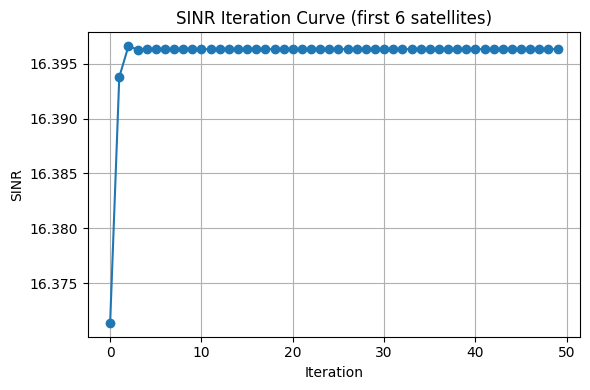

In [ ]:

import matplotlib.pyplot as plt
k_to_plot = 6

if k_to_plot in sinr_itr_curves:
    plt.figure(figsize=(6, 4))
    plt.plot(sinr_itr_curves[k_to_plot], marker='o')
    plt.title(f"SINR Iteration Curve (first {k_to_plot} satellites)")
    plt.xlabel("Iteration")
    plt.ylabel("SINR")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print(f"No curve found for k = {k_to_plot}")


I want to add that if the jammer and the desired source are within the diffraction limits of the receiver aperture, then we are in bigger trouble as you cannot use beamforming to null out the jammer. Then nonlinear subtraction methods may have to be used and that will hit the receiver sensitivity a lot I a sure. But without it there is no hope as both signal and jammer are smack on the beam.